In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy.table import Table
import matplotlib.pyplot as pl
import matplotlib.colors as mc
import matplotlib.collections as mcoll
from scipy.interpolate import NearestNDInterpolator
from numpy import linspace, array, logspace, sin, cos, pi, arange, sqrt, arctan2, arccos
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from coords import *
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects
from astropy.coordinates import Angle
import astropy.units as u
import cmasher as cmr


import lmfit
from lmfit import minimize, Parameters,create_params
from matplotlib.collections import LineCollection


from collections import Counter
from scipy.spatial.distance import cdist
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import NearestNeighbors


In [ ]:
plt.style.use('classic')
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["font.size"] = "16"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

    

def rotate(x,y,theta):
    xprime = x*cos(theta) - y*sin(theta)
    yprime = x*sin(theta) + y*cos(theta)
    return xprime, yprime

l_offset = np.radians(-0.0558)
b_offset = np.radians(-0.0462)
x_offset = Rsun*l_offset
y_offset = Rsun*b_offset

#############################
# create class that stores a ring
#############################

class Ring:

    def __init__(self,t,a,bb,z,v0,theta,xyzsun,vxyzsun,alpha=0.4):
        self.t     = t
        self.a     = a
        self.bb     = bb
        self.z0    = z
        self.v0    = v0
        self.theta = theta
        self.x     = a*cos(t)
        self.y     = -bb*sin(t)
        self.z     = self.z0*sin(-2*t + alpha)
        self.R     = sqrt(self.x**2+self.y**2)
        self.phi   = -arctan2(self.y,self.x)
        self.ephix = -sin(self.phi) # unit vector parallel to circle
        self.ephiy = -cos(self.phi) # unit vector parallel to circle
        norm       = sqrt((a*sin(t))**2+(bb*cos(t))**2)
        self.ex    = -a*sin(t)/norm # unit vector parellel to ellipse
        self.ey    = -bb*cos(t)/norm  # unit vector parallel to ellipse
        self.cosalpha = self.ex*self.ephix + self.ey*self.ephiy
        self.vphi  = self.R[0]*self.v0/self.R # assume conservation of angular momentum
        self.v     = self.vphi/self.cosalpha # total speed along the orbit
        self.vx    = +self.v*self.ex
        self.vy    = +self.v*self.ey
        self.vz    = np.zeros(t.size)
        self.x,self.y   = rotate(self.x,self.y,theta)
        self.vx,self.vy = rotate(self.vx,self.vy,theta)
        self.X,self.Y,self.Z,self.vX,self.Vy,self.vZ = xyz2XYZ(self.x,self.y,self.z,self.vx,self.vy,self.vz,xyzsun[0],xyzsun[1],xyzsun[2],vxyzsun[0],vxyzsun[1],vxyzsun[2])
        # Convert Sgr A* offset from degrees to radians
        l_offset = np.radians(0.0558)
        b_offset = np.radians(-0.0462)
        x_offset = Rsun*l_offset
        y_offset = 0
        z_offset = Rsun*b_offset
        # Calculate galactic coordinates accounting for Sgr A* offset
        self.l,self.b,self.r,self.vl,self.vb,self.vr = xyz2lbr(
            self.x,self.y,self.z,self.vx,self.vy,self.vz,
            xyzsun[0],xyzsun[1],xyzsun[2],vxyzsun[0],vxyzsun[1],vxyzsun[2])
        self.l += l_offset
        self.b += b_offset
        self.x += x_offset
        self.y += y_offset
        self.z += z_offset
        self.mu_l, self.mu_b = vlb_2_mulb(self.r, self.vl*100, self.vb*100)
        self.mu_l, self.mu_b = vlb_2_mulb(self.r,self.vl*100,self.vb*100)

        
#############################
# define sun position & velocity
#############################

xsun  = 0.0
ysun  = -8.2
zsun  = 0.0
vxsun = -2.2
vysun = 0.0
vzsun = 0.0
xyzsun  = [xsun, ysun, zsun ]
vxyzsun = [vxsun,vysun,vzsun]
phisun  = arctan2(ysun,xsun)



In [ ]:
def lb_lv_plots(Rings):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
    fig.set_facecolor('white')
    ax[0].set_facecolor('white')

    ### Scatter cloud points in lbv ###
    color_list = ['blue', 'cyan', 'gray' ,'mistyrose', 'red']
    cmap = (mpl.colors.ListedColormap(color_list))


    back_ind = np.where(Rings.y>=y_offset)
    fore_ind = np.where(Rings.y<=y_offset)
    


    ### Plot Rings LB ###
    ax[0].plot(np.degrees(Rings.l[back_ind[0:-1]]),np.degrees(Rings.b[back_ind[0:-1]]),c='red')
    ax[0].plot(np.degrees(Rings.l[fore_ind[0:]]),np.degrees(Rings.b[fore_ind[0:]]),c='blue', linewidth=2, zorder=2)

    for i in range(0,len(plot_cat_agg)):
        
        if plot_cat_agg['leaf_id'][i] not in cat_agg['leaf_id']:
            marker = 'X'
            alpha = 0.5
        else:
            marker = 'o'
            alpha =1.

        if plot_cat_agg['NF_decision'][i] == 'N':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, c=color_list[0], s=120 , alpha = alpha)
        if plot_cat_agg['NF_decision'][i] == 'LN':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, c=color_list[1], s=120, alpha = alpha)
        if plot_cat_agg['NF_decision'][i] == 'U':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, c=color_list[2], s=120, alpha = alpha)
        if plot_cat_agg['NF_decision'][i] == 'LF':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, c=color_list[3], s=120, alpha = alpha)
        if plot_cat_agg['NF_decision'][i] == 'F':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, c=color_list[4], s=120, alpha = alpha)
        if plot_cat_agg['NF_decision'][i] == 'nan':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)


    ax[0].set_xlabel('longitude [deg]', labelpad=20)
    ax[0].set_ylabel('latitude [deg]', labelpad=10)
    ax[0].set_xlim(1.8,-1.)
    ax[0].set_ylim(-0.3,0.1)


    ### Plot Rings LV ###
    ax[1].plot(np.degrees(Rings.l[back_ind[0:-1]]),Rings.vr[back_ind[0:-1]],c='red')
    ax[1].plot(np.degrees(Rings.l[fore_ind[0:]]),Rings.vr[fore_ind[0:]],c='blue', linewidth=2, zorder=2)

    for i in range(0,len(plot_tab)):
        
        if plot_tab['leaf_id'][i] not in cat_tab['leaf_id']:
            marker = 'X'
            alpha = 0.5
        else:
            marker = 'o'
            alpha = 1.

        if plot_tab['NF_decision'][i] == 'N':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, c=color_list[0], s=120, alpha = alpha)
        if plot_tab['NF_decision'][i] == 'LN':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, c=color_list[1], s=120, alpha = alpha)
        if plot_tab['NF_decision'][i] == 'U':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, c=color_list[2], s=120, alpha = alpha)
        if plot_tab['NF_decision'][i] == 'LF':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, c=color_list[3], s=120, alpha = alpha)
        if plot_tab['NF_decision'][i] == 'F':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, c=color_list[4], s=120, alpha = alpha)
        if plot_tab['NF_decision'][i] == 'nan':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)






    ax[1].set_xlabel('longitude [deg]', labelpad=20)
    ax[1].set_ylabel('velocity [km/s]', labelpad=10)
    ax[1].set_xlim(1.8,-1.)
    ax[1].set_ylim(-150,150)
    
    
    ax[0].text(.9, 1.10, 'a = {:.3f}, b = {:.3f}, z = {:.3f}, v0 = {:.2f}, theta_deg = {:.1f}, red_chisq = {:.2f}'.format(Rings.a,Rings.bb,Rings.z0, Rings.v0, np.degrees(Rings.theta),out.redchi), fontsize=15, ha='right', va='top', 
            transform=ax[0].transAxes)
    
    
    plt.show()

    return 

In [ ]:
def lb_lv_plots_postcolor(Rings,out):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
    fig.set_facecolor('white')
    ax[0].set_facecolor('white')

    ### Scatter cloud points in lbv ###
    color_list = ['blue', 'cyan', 'gray' ,'mistyrose', 'red']
    cmap = (mpl.colors.ListedColormap(color_list))


    back_ind = np.where(Rings.y>=y_offset)
    fore_ind = np.where(Rings.y<=y_offset)
    


    ### Plot Rings LB ###
    ax[0].plot(np.degrees(Rings.l[back_ind[0:-1]]),np.degrees(Rings.b[back_ind[0:-1]]),c='red')
    ax[0].plot(np.degrees(Rings.l[fore_ind[0:]]),np.degrees(Rings.b[fore_ind[0:]]),c='blue', linewidth=2, zorder=2)


    divnorm =mc.TwoSlopeNorm(vmin=-1., vcenter=0, vmax=1.)
    #cmap    = cmr.redshift_r
    cmap    = 'bwr_r'
    for i in range(0,len(plot_cat_agg)):

        if plot_cat_agg['leaf_id'][i] not in cat_agg['leaf_id']:
            marker = 'X'
            alpha = 1.
        else:
            marker = 'o'
            alpha =1.
            

        if plot_cat_agg['NF_decision'][i] != 'nan':
            sc = ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, 
                           c=plot_post_tab_agg['mu'][i], s=120, 
                           cmap=cmap, norm=divnorm, alpha = alpha)

        if plot_cat_agg['NF_decision'][i] == 'nan':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)


    ax[0].set_xlabel('longitude [deg]', labelpad=20)
    ax[0].set_ylabel('latitude [deg]', labelpad=10)
    ax[0].set_xlim(1.8,-1.)
    ax[0].set_ylim(-0.3,0.1)



    ### Plot Rings LV ###
    ax[1].plot(np.degrees(Rings.l[back_ind[0:-1]]),Rings.vr[back_ind[0:-1]],c='red')
    ax[1].plot(np.degrees(Rings.l[fore_ind[0:]]),Rings.vr[fore_ind[0:]],c='blue', linewidth=2, zorder=2)

    for i in range(0,len(plot_tab)):
        
        if plot_tab['leaf_id'][i] not in cat_tab['leaf_id']:
            marker = 'X'
            alpha = 1.
        else:
            marker = 'o'
            alpha = 1.

        if plot_tab['NF_decision'][i] != 'nan':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, 
                      c=plot_post_tab['mu'][i], s=120, 
                      cmap=cmap, norm=divnorm, alpha = alpha)


        if plot_tab['NF_decision'][i] == 'nan':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)


    ax[1].set_xlabel('longitude [deg]', labelpad=20)
    ax[1].set_ylabel('velocity [km/s]', labelpad=10)
    ax[1].set_xlim(1.8,-1.)
    ax[1].set_ylim(-150,150)
    
    cax = fig.add_axes([0.15, 0.97, 0.73, 0.03])
    cb = plt.colorbar(sc, ax=ax[0], orientation='horizontal', cax=cax)   
    ax[0].text(.9, 1.4, 'a = {:.3f}, b = {:.3f}, z = {:.3f}, v0 = {:.2f}, theta_deg = {:.1f}, red_chisq = {:.2f}'.format(Rings.a,Rings.bb,Rings.z0, Rings.v0, np.degrees(Rings.theta),out.redchi), fontsize=15, ha='right', va='top', 
            transform=ax[0].transAxes)
    
    
    plt.show()

    return 

In [ ]:
def load_data(path, sep='\s+', cols=[0,1,2,3],names=['l', 'b', 'v', 'near_far']):
    return pd.read_csv(path, sep=sep, header=None, names=names)
    #lk, bk, vk, NF = data['l'].values, data['b'].values, data['v'].values, data['near_far'].values
    #return data, lk, bk, vk, NF
    #Find near and far point

In [ ]:
### create a function that is a continuous distribution between NF on the ring itself
# take the y indices of the ring that are in front of the offset = Near; behind = Far
# values are relative weights in the distribution?
def ring_NF_dist_y(Rings):
    back_ind = np.where(Rings.y>=y_offset)
    fore_ind = np.where(Rings.y<y_offset)

    y_NF =  Rings.y.copy()
    y_NF=np.where(Rings.y<y_offset,y_NF,-(Rings.y - np.nanmin(Rings.y[back_ind]) )/ (np.nanmax(Rings.y[back_ind]) - np.nanmin(Rings.y[back_ind])))
    y_NF=np.where(Rings.y>=y_offset,y_NF,(Rings.y - np.nanmin(Rings.y[fore_ind]) )/ (np.nanmax(Rings.y[fore_ind]) - np.nanmin(Rings.y[fore_ind])))
    #y_NF=np.where(Rings.y<y_offset,y_NF,-1)
    #y_NF=np.where(Rings.y>=y_offset,y_NF,1)

    return back_ind, fore_ind, y_NF


def ring_NF_dist(Rings):
    back_ind = np.where(Rings.r>=8.2)
    fore_ind = np.where(Rings.r<8.2)

    y_NF =  Rings.r.copy()
    y_NF[back_ind] = -(Rings.r[back_ind] - 8.2 )/ (np.nanmax(Rings.r[back_ind]) - 8.2)
    y_NF[fore_ind] =  1-(Rings.r[fore_ind] - np.nanmin(Rings.r[fore_ind]) )/ (8.2 - np.nanmin(Rings.r[fore_ind]))
    #y_NF=np.where(Rings.y<y_offset,y_NF,-1)
    #y_NF=np.where(Rings.y>=y_offset,y_NF,1)

    return back_ind, fore_ind, y_NF

def calculate_mahalanobis_distances(data, model):
    cov = np.cov(data.T) 
    inv_cov = np.linalg.inv(cov)
    distances = cdist(data, model, metric='mahalanobis', VI=inv_cov)
    return distances, inv_cov


def min_distance_mahalanobis(data, model):

    # compute distances for every point on the stream
    dist, inv_cov = calculate_mahalanobis_distances(data, model)

    # find the minima 
    glob_min_idxs =[]
    for i in range(len(data)):
        glob_min_idxs.append(np.argwhere(dist[i]==np.min(dist[i])).ravel()[0])
    return glob_min_idxs, dist #returns all distance values and minima index

def normalizelbv(l,b,v):
    lmin, lmax = -0.6, 1.7
    bmin, bmax = -0.3, 0.1
    vmin, vmax = -110., 100.
    
    #using approximate extents of the data in l,b,v to normalize between -1 and 1
    norml = 2*((l - lmin) / (lmax - lmin)) -1. 
    normb = 2*((b - bmin) / (bmax - bmin)) -1. 
    normv = 2*((v - vmin) / (vmax - vmin)) -1. 
    
    return norml,normb,normv

def distancelbv(l, b, v, l0, b0, v0):
    #typical Cartesian distance measurement 
    d_l = l - l0
    d_b = b - b0
    d_v = v - v0
    dis = np.sqrt( d_l**2 + d_b**2 + d_v**2)
    return dis


def min_distancelbv(streaml, streamb, streamv, P):
    """
    Compute minimum/a distance/s between
    a point P[x0,y0,z0] and a curve (x,y,z).
    
    Returns min indexes and distances array.
    """
    # compute distances for every point on the stream
    d = distancelbv(streaml, streamb, streamv, P[0], P[1], P[2])

    # find the minima 
    glob_min_idxs = np.argwhere(d==np.min(d)).ravel()
    return glob_min_idxs, d #returns all distance values and minima index


#Gaussian function for the PPDF distributions (used in KNN search)
def gaussian(x, A, mu, sigma):
    return A * np.exp(- (x - mu)**2 / (2.* (sigma**2 )))

#Save normed data as a class
class norm_data:    
    def __init__(self, norml0, normb0, normv0, NF):
        self.l0 = norml0
        self.b0 = normb0
        self.v0 = normv0
        self.NF = NF #Cloud NF is decided from the PPDF centers, already normalized to [-1,1]

In [ ]:
def normedr_to_pc(r, A):
    '''takes in a normalized LOS position, r in (-1,1) scaling, 
    as well as a normalization constant A (in pc) that corresponds to the radius of the ellipse.
    returns top-down y value for distance from SgrA* in PARSECS
    
    y < 0 in NEAR, y>0 is FAR
    
    '''
    
    return A*r

# LMFIT time

In [ ]:
###Read in data to scatter plot in lbv 
cat_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/synth_table.tex")
post_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/posterior_fits.tex")

##remove the rows with NaN NF decisions 
non_fitting_rows = list(np.where(cat_tab['NF_decision']=='nan')[0])
pixel_masked_rows =  np.where(cat_tab['lb_pixel_mask']==0)[0]

for i in pixel_masked_rows:
    if i not in non_fitting_rows:
        non_fitting_rows.append(i)

#non_fitting_rows.append((np.where(cat_tab['leaf_id']=='12')[0][0]))

non_fitting_rows.append((np.where(cat_tab['leaf_id']=='10')[0][0]))
non_fitting_rows.append((np.where(cat_tab['leaf_id']=='9')[0][0]))
non_fitting_rows.append((np.where(cat_tab['leaf_id']=='13')[0][0]))
non_fitting_rows.append((np.where(cat_tab['leaf_id']=='14')[0][0]))
#non_fitting_rows.append((np.where(cat_tab['leaf_id']=='8b')[0][0]))
#non_fitting_rows.append((np.where(cat_tab['leaf_id']=='8c')[0][0]))
#non_fitting_rows.append((np.where(cat_tab['leaf_id']=='11b')[0][0]))
#non_fitting_rows.append((np.where(cat_tab['leaf_id']=='11c')[0][0]))

post_tab.remove_rows(non_fitting_rows)
cat_tab.remove_rows(non_fitting_rows)

cat_index = cat_tab['leaf_id']
cloud_name = cat_tab['cloud_name']
NF_decision = cat_tab['NF_decision']
lb_pixel_mask = cat_tab['lb_pixel_mask']

post_A = post_tab['A_MC']
post_mu = post_tab['mu_MC']
post_sigma = post_tab['sigma_MC']



## aggregate table that pulls out the largest mask
## to represent the l,b N/F/U position

cat_group = cat_tab.group_by('lb_pixel_mask')
cat_group_mask = cat_group.groups.keys['lb_pixel_mask'] == 1

cat_agg = cat_group.groups[cat_group_mask]


## For plotting only
plot_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/synth_table.tex")
plot_cat_group = plot_tab.group_by('lb_pixel_mask')
plot_cat_group_mask = plot_cat_group.groups.keys['lb_pixel_mask'] == 1
plot_cat_agg = plot_cat_group.groups[plot_cat_group_mask]
plot_post_tab = Table.read("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/posterior_fits.tex")
plot_post_tab_agg = plot_post_tab[np.where(plot_tab['lb_pixel_mask']==1)]



In [9]:
####################################################
### Pre-process the DATA to normalize to [-1,1] ###
####################################################
norml0, normb0, normv0 = normalizelbv(cat_tab['l'],cat_tab['b'], cat_tab['v'])
Ndata = norm_data(norml0, normb0, normv0, post_mu)

In [10]:
params = create_params(a_rings={'value': 0.09   , 'min': 0.01, 'max': 0.3, 'vary': True},
                       b_rings={'value': 0.055  , 'min': 0.01, 'max': 0.2, 'vary': True},
                       z_rings={'value': 0.0125 , 'min': 0.00, 'max': 0.05, 'vary': True},
                       v_rings={'value': 130.0  , 'min': 100.0, 'max': 150.0, 'vary': True},
                       theta_rings={'value': 25  , 'min': 0, 'max': 180, 'vary': True},
                       ddphi={'value': 0.001  , 'min': 0.00005, 'max': 0.01, 'vary': False}
                          )

params_OFF = create_params(a_rings={'value': 0.1   , 'min': 0.01, 'max': 0.3, 'vary': True},
                       b_rings={'value': 0.1  , 'min': 0.01, 'max': 0.2, 'vary': True},
                       z_rings={'value': 0.0125 , 'min': 0.00, 'max': 0.05, 'vary': True},
                       v_rings={'value': 110.0  , 'min': 100.0, 'max': 150.0, 'vary': True},
                       theta_rings={'value': 30  , 'min': 15, 'max': 360, 'vary': True},
                       ddphi={'value': 0.001  , 'min': 0.00005, 'max': 0.01, 'vary': False}
                          )

params_dphi = create_params(a_rings={'value': 0.09   , 'min': 0.01, 'max': 0.3, 'vary': True},
                       b_rings={'value': 0.055  , 'min': 0.01, 'max': 0.2, 'vary': True},
                       z_rings={'value': 0.0125 , 'min': 0.00, 'max': 0.05, 'vary': True},
                       v_rings={'value': 130.0  , 'min': 100.0, 'max': 150.0, 'vary': True},
                       theta_rings={'value': 25  , 'min': 0, 'max': 180, 'vary': True},
                       ddphi={'value': 0.001  , 'min': 0.00005, 'max': 0.01, 'vary': True}
                          )

In [11]:
#############################
###Uncertainty of fitting?###
#############################
# Store the y-axis top-down values of all of the pc LOS distances 
# from each iteration of the fitting for each cloud.
# Then we'll make a histogram of the various distances for each cloud,
# and get the uncertainties in pc?



In [109]:


def ring_resid(params, l,b,v):
    
    a_rings=params['a_rings']
    b_rings=params['b_rings']
    z_rings=params['z_rings']
    v_rings=params['v_rings']
    theta_rings=params['theta_rings']
    ddphi=params['ddphi']
    
    dphi = np.radians(ddphi)
    phi  = arange(phisun+dphi/2,phisun+2*pi,dphi)
    
    Rings = Ring(phi,a_rings,b_rings,z_rings,v_rings, np.radians(theta_rings),xyzsun,vxyzsun)
            
    ### Pre-process the given MODEL; normalize to [-1,1] ###
    normELL_l, normELL_b, normELL_v = normalizelbv(np.degrees(Rings.l),np.degrees(Rings.b),Rings.vr)
    back_ind, fore_ind, y_NF = ring_NF_dist_y(Rings) #finds the N/F on the ellipse
    Nrings = norm_data(normELL_l, normELL_b, normELL_v , y_NF)
    
    
    ### Perform KNN search on the model and find the neighbor distances and indices in the model
    nn = NearestNeighbors(n_neighbors=10, metric='minkowski')
    nn.fit(np.vstack([Nrings.l0,Nrings.b0,Nrings.v0,Nrings.NF]).T)
    distances, indices = nn.kneighbors(np.vstack([Ndata.l0,Ndata.b0,Ndata.v0,Ndata.NF]).T)
    
    
    ### for each catalogue point, find the minimum residual between pt and the ellipse
    #   and save the min to array
    min_d_list = []
    nf_penalty_list = [] #saves how closely the nearest point matches the NF position posterior based on KNN search
    
    model_data = np.vstack([Nrings.l0,Nrings.b0,Nrings.v0]).T
    cat_data = np.vstack([Ndata.l0,Ndata.b0,Ndata.v0]).T
    glob_min_idxs, dist_lbv = min_distance_mahalanobis(cat_data,model_data)
    
    cat_los_i = [] #list for values of LOS in parsec for each cloud
    
    for i in range(len(cat_tab)):

        ### store min distance into the min dist list ###
        min_d_list.append(dist_lbv[i][glob_min_idxs[i]])
        
        
        
        ### Find how well each point agrees with the N/F degree of the model ellipse ###
        
        idx=indices[i]
        dist = distances[i]
        neighbors_nf = Nrings.NF[idx]
        common_nf = Counter(neighbors_nf).most_common(1)[0][0]

        post_dist_value = gaussian(common_nf ,post_A[i],post_mu[i],post_sigma[i])


        nf_penalty = post_A[i] - post_dist_value #this fits by seeing how close the point is to the peak on the posterior curve
        #nf_penalty = post_mu[i] - common_nf #this fits by comparing how offset the point is from the center of the gaussian
        nf_penalty_list.append(abs(nf_penalty))  


    lists_of_lists = [min_d_list, nf_penalty_list]
    resid_list = [sum(x) for x in zip(*lists_of_lists)] #add the values of the lists together

    return resid_list
    

In [110]:

out = minimize(ring_resid, params, method='nelder', args=(Ndata.l0,Ndata.b0,Ndata.v0))



In [111]:
out

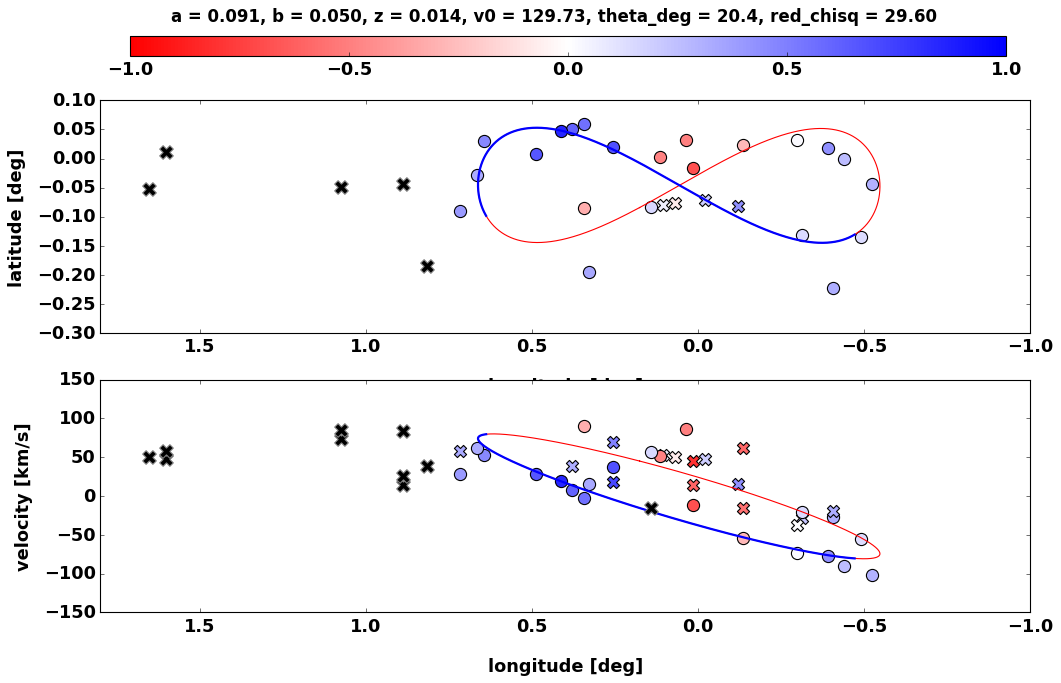

In [112]:
dphi = np.radians(0.001)
phi  = arange(phisun+dphi/2,phisun+2*pi,dphi)

Rings_out = Ring(phi,
                  out.params['a_rings'].value,
                  out.params['b_rings'].value,
                  out.params['z_rings'].value,
                  out.params['v_rings'].value, 
                  np.radians(out.params['theta_rings'].value),
                  xyzsun,vxyzsun)
'''
Rings_out_off = Ring(phi,
                  out_off.params['a_rings'].value,
                  out_off.params['b_rings'].value,
                  out_off.params['z_rings'].value,
                  out_off.params['v_rings'].value, 
                  np.radians(out_off.params['theta_rings'].value),
                  xyzsun,vxyzsun)'''

lb_lv_plots_postcolor(Rings_out, out)
#lb_lv_plots_postcolor(Rings_out_off, out_off)

#Save output to dat files
list(vars(Rings_out).items())

save_Rings_out = Table()
Rings_out_fit_params = Table()

for i in list(vars(Rings_out).items()):
    if type(i[1])!=np.float64:
        save_Rings_out[i[0]] = i[1]
    if type(i[1])==np.float64:
        Rings_out_fit_params[i[0]] = [i[1]]
        
ascii.write(save_Rings_out, "/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/Rings_out.dat", overwrite=True)  
ascii.write(Rings_out_fit_params,"/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/Rings_out_params.dat", overwrite=True)


In [16]:
def colored_line(x, y, c, ax, **lc_kwargs):
    """
    Plot a line with a color specified along the line by a third value.

    It does this by creating a collection of line segments. Each line segment is
    made up of two straight lines each connecting the current (x, y) point to the
    midpoints of the lines connecting the current point with its two neighbors.
    This creates a smooth line with no gaps between the line segments.

    Parameters
    ----------
    x, y : array-like
        The horizontal and vertical coordinates of the data points.
    c : array-like
        The color values, which should be the same size as x and y.
    ax : Axes
        Axis object on which to plot the colored line.
    **lc_kwargs
        Any additional arguments to pass to matplotlib.collections.LineCollection
        constructor. This should not include the array keyword argument because
        that is set to the color argument. If provided, it will be overridden.

    Returns
    -------
    matplotlib.collections.LineCollection
        The generated line collection representing the colored line.
    """
    if "array" in lc_kwargs:
        warnings.warn('The provided "array" keyword argument will be overridden')

    # Default the capstyle to butt so that the line segments smoothly line up
    default_kwargs = {"capstyle": "butt"}
    default_kwargs.update(lc_kwargs)

    # Compute the midpoints of the line segments. Include the first and last points
    # twice so we don't need any special syntax later to handle them.
    x = np.asarray(x)
    y = np.asarray(y)
    x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
    y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))

    # Determine the start, middle, and end coordinate pair of each line segment.
    # Use the reshape to add an extra dimension so each pair of points is in its
    # own list. Then concatenate them to create:
    # [
    #   [(x1_start, y1_start), (x1_mid, y1_mid), (x1_end, y1_end)],
    #   [(x2_start, y2_start), (x2_mid, y2_mid), (x2_end, y2_end)],
    #   ...
    # ]
    coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[:, np.newaxis, :]
    coord_mid = np.column_stack((x, y))[:, np.newaxis, :]
    coord_end = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
    segments = np.concatenate((coord_start, coord_mid, coord_end), axis=1)

    lc = LineCollection(segments, **default_kwargs)
    lc.set_array(c)  # set the colors of each segment

    return ax.add_collection(lc)

In [17]:
def lb_lv_plots_postcolor_grad(Rings, out):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
    fig.set_facecolor('white')
    ax[0].set_facecolor('white')

    ### Scatter cloud points in lbv ###
    color_list = ['blue', 'cyan', 'gray' ,'mistyrose', 'red']
    cmap = (mpl.colors.ListedColormap(color_list))


    back_ind = np.where(Rings.y>=y_offset)
    fore_ind = np.where(Rings.y<=y_offset)
    
    ringcmap = 'bwr_r' #cmr.prinsenvlag


    ### Plot Rings LB ###
    ringcolor = ring_NF_dist(Rings)[2]
    lines = colored_line(np.degrees(Rings.l),np.degrees(Rings.b), ringcolor, ax[0], linewidth=5, cmap=ringcmap,zorder=1)

    #ax[0].plot(np.degrees(Rings.l[back_ind[0:-1]]),np.degrees(Rings.b[back_ind[0:-1]]),c='red')
    #ax[0].plot(np.degrees(Rings.l[fore_ind[0:]]),np.degrees(Rings.b[fore_ind[0:]]),c='blue', linewidth=2, zorder=2)


    divnorm =mc.TwoSlopeNorm(vmin=-1., vcenter=0, vmax=1.)
    #cmap    = cmr.redshift_r
    cmap    = 'bwr_r'
    for i in range(0,len(plot_cat_agg)):

        if plot_cat_agg['leaf_id'][i] not in cat_agg['leaf_id']:
            marker = 'X'
            alpha = 1.
        else:
            marker = 'o'
            alpha =1.
            

        if plot_cat_agg['NF_decision'][i] != 'nan':
            sc = ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, 
                           c=plot_post_tab_agg['mu'][i], s=120, 
                           cmap=cmap, norm=divnorm, alpha = alpha)

        if plot_cat_agg['NF_decision'][i] == 'nan':
            ax[0].scatter(plot_cat_agg['l'][i],plot_cat_agg['b'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)


    ax[0].set_xlabel('longitude [deg]', labelpad=20)
    ax[0].set_ylabel('latitude [deg]', labelpad=10)
    ax[0].set_xlim(1.8,-1.)
    ax[0].set_ylim(-0.3,0.1)



    ### Plot Rings LV ###
    ringcolor = ring_NF_dist(Rings)[2]
    lines = colored_line(np.degrees(Rings.l),Rings.vr, ringcolor, ax[1], linewidth=5, cmap=ringcmap,zorder=1)

    #ax[1].plot(np.degrees(Rings.l[back_ind[0:-1]]),Rings.vr[back_ind[0:-1]],c='red')
    #ax[1].plot(np.degrees(Rings.l[fore_ind[0:]]),Rings.vr[fore_ind[0:]],c='blue', linewidth=2, zorder=2)

    for i in range(0,len(plot_tab)):
        
        if plot_tab['leaf_id'][i] not in cat_tab['leaf_id']:
            marker = 'X'
            alpha = 1.
        else:
            marker = 'o'
            alpha = 1.

        if plot_tab['NF_decision'][i] != 'nan':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, 
                      c=plot_post_tab['mu'][i], s=120, 
                      cmap=cmap, norm=divnorm, alpha = alpha)


        if plot_tab['NF_decision'][i] == 'nan':
            ax[1].scatter(plot_tab['l'][i],plot_tab['v'][i], marker=marker, s=150, edgecolor='gray', zorder=3, c='k', alpha = alpha)


    ax[1].set_xlabel('longitude [deg]', labelpad=20)
    ax[1].set_ylabel('velocity [km/s]', labelpad=10)
    ax[1].set_xlim(1.8,-1.)
    ax[1].set_ylim(-150,150)
    
    cax = fig.add_axes([0.15, 0.97, 0.73, 0.03])
    cb = plt.colorbar(sc, ax=ax[0], orientation='horizontal', cax=cax)   
    ax[0].text(.9, 1.4, 'a = {:.3f}, b = {:.3f}, z = {:.3f}, v0 = {:.2f}, theta_deg = {:.1f}, red_chisq = {:.2f}'.format(Rings.a,Rings.bb,Rings.z0, Rings.v0, np.degrees(Rings.theta),out.redchi), fontsize=15, ha='right', va='top', 
            transform=ax[0].transAxes)
    
    cax2 = fig.add_axes([.97, 0.1, 0.03, 0.8])
    cb2 = plt.colorbar(lines, orientation='vertical', cax=cax2)
    cb2.set_label('Ring LOS N/F', rotation=270)
    
    
    plt.show()

    return 

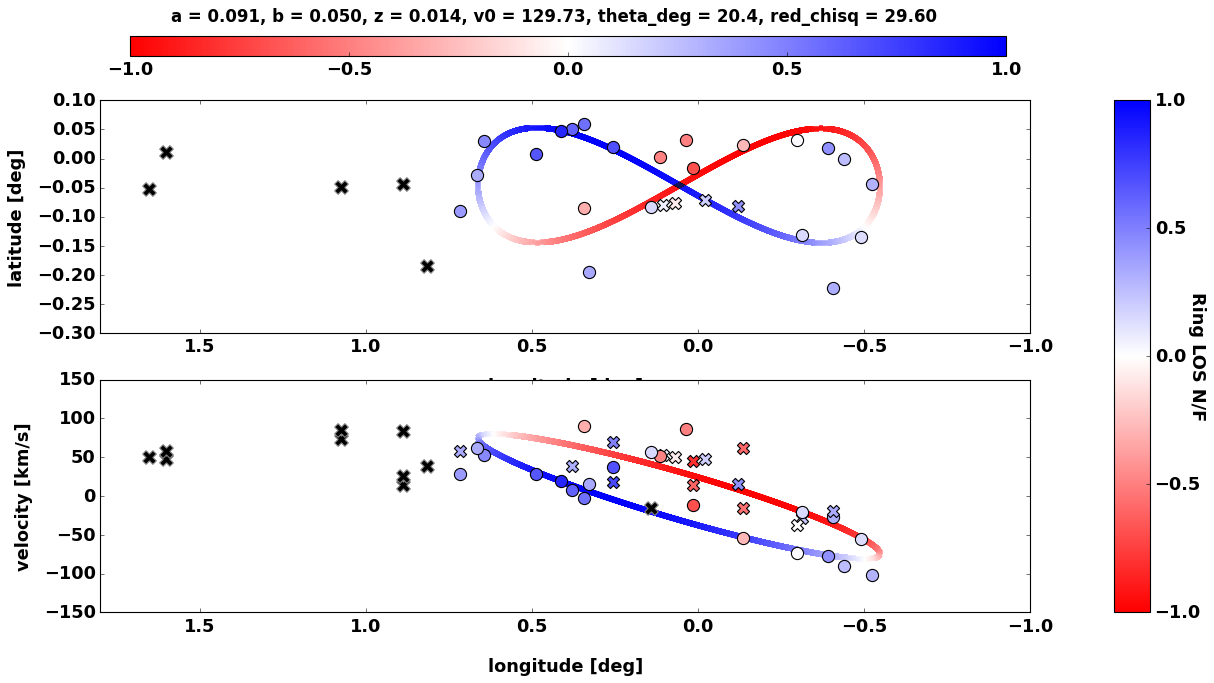

In [18]:

lb_lv_plots_postcolor_grad(Rings_out, out)
#lb_lv_plots_postcolor_grad(Rings_out_off, out_off)

# Top-down visualizations!

In [ ]:
def denorm_yNF_value(y_NF, Rings_out):
        
    """This function takes in a normalized array (-1,1) and converts it to a top-down y-axis
    distance from SgrA* based on that output from the best fitting x2 ellipse (Rings_out).
    
    Negative values are on the NEAR SIDE in front of SgrA*
    Positive values are on the FAR SIDE behind SgrA*
    
    Results are in kiloparsecs!! 
    """
    
    term1 = (y_NF + 1)/2
    term2 = (np.nanmax(Rings_out.r) - np.nanmin(Rings_out.r))
    
    real_y = (term1*term2) + np.nanmin(Rings_out.r)

    #returns the LOS distance on the ring from SgrA* in kpc
    return real_y

def denorm_sigma_value(NFsigma, Rings_out):

    minkpc =  8.2 - np.nanmin(Rings_out.r)
    maxkpc =  8.2 - np.nanmax(Rings_out.r)
    widthkpc = minkpc - maxkpc
    
    term1 = (NFsigma)
    term2 = widthkpc - 0
    
    real_sig = (term1*term2) 

    #returns the LOS distance on the ring from SgrA* in kpc
    return real_sig




In [ ]:
dphi = np.radians(0.001)
phi  = arange(phisun+dphi/2,phisun+2*pi,dphi)
Rings_inner = Ring(phi,
                  0.016,
                  0.010,
                  0.014,
                  100.00, 
                  np.radians(15.0),
                  xyzsun,vxyzsun)

Rings_avg = Ring(phi,
                  0.091,
                  0.050,
                  0.014,
                  129.73, 
                  np.radians(20.0),
                  xyzsun,vxyzsun)

Rings_outer = Ring(phi,
                  0.136,
                  0.104,
                  0.013,
                  102.69, 
                  np.radians(49.9),
                  xyzsun,vxyzsun)

In [ ]:
plot_post_tab_agg[25]

In [ ]:
denorm_sigma_value(plot_post_tab_agg['sigma_MC'][25], Rings_inner), denorm_sigma_value(plot_post_tab_agg['sigma_MC'][25], Rings_outer)

In [ ]:
##convert the cloud posterior sigmas into pc uncertainties?

cat_sig_list = []
cat_y_list = []
for i in range(len(plot_post_tab_agg[:-3])):
    
    
    lowerlim_sig_kpc = denorm_sigma_value(plot_post_tab_agg['sigma_MC'][i], Rings_inner)
    avglim_sig_kpc   = denorm_sigma_value(plot_post_tab_agg['sigma_MC'][i], Rings_avg)
    upperlim_sig_kpc = denorm_sigma_value(plot_post_tab_agg['sigma_MC'][i], Rings_outer)
    
    #combinesig_kpc = np.sqrt(lowerlim_sig_kpc**2 + upperlim_sig_kpc**2)
    combinesig_kpc = (lowerlim_sig_kpc**2 + upperlim_sig_kpc**2 + avglim_sig_kpc**2)**(1./2.)
    
    cat_sig_list.append(combinesig_kpc)
    
    lowerlim_y = denorm_yNF_value(plot_post_tab_agg['mu_MC'][i],Rings_inner)
    avglim_y   = denorm_yNF_value(plot_post_tab_agg['mu_MC'][i],Rings_avg)
    upperlim_y = denorm_yNF_value(plot_post_tab_agg['mu_MC'][i],Rings_outer)
    
    #combiney_kpc = np.mean([lowerlim_y,  upperlim_y])
    combiney_kpc = np.mean([lowerlim_y,  upperlim_y, avglim_y])
    
    cat_y_list.append(8.2-combiney_kpc)
    
    print(plot_cat_agg['leaf_id'][i], combinesig_kpc, (8.2-combiney_kpc)*1e3  )
    
    

In [ ]:
cat_sig_list[25]

In [ ]:
x_offset

In [ ]:
def los_l_to_xyz(l):
    
    rr = np.linspace((8.2--0.159),(8.2-0.159), 100)
    x,y,z,vx,vy,vz=lbr2xyz(np.deg2rad(l),np.deg2rad(0),rr,
                       0,0,0,xsun=-8.2,ysun=0.0,zsun=0.0,vxsun=0.0,vysun=2.2,vzsun=0.0)
    return -y , x

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
fig.set_facecolor('white')
fig.set_facecolor('white')


ringcmap = 'bwr_r' #cmr.prinsenvlag


### Plot Rings LB ###
min_ringcolor = ring_NF_dist(Rings_inner)[2]
min_lines = colored_line(Rings_inner.x ,Rings_inner.y , min_ringcolor, ax, linewidth=5, cmap=ringcmap,zorder=10)


avg_ringcolor = ring_NF_dist(Rings_avg)[2]
avg_lines = colored_line(Rings_avg.x ,Rings_avg.y , avg_ringcolor, ax, linewidth=5, cmap=ringcmap,zorder=10)


max_ringcolor = ring_NF_dist(Rings_outer)[2]
max_lines = colored_line(Rings_outer.x ,Rings_outer.y , max_ringcolor, ax, linewidth=5, cmap=ringcmap,zorder=10)

sgra = ax.scatter(-y_offset , 0 , marker = '*', s=150 ,color = 'k',zorder=10)


long_list = np.arange(-1.5, 1.5, 0.5)
axt_ticks = []
for ll in long_list:
    xline, rrline = los_l_to_xyz(ll)
    ax.plot(xline, rrline , linestyle = '--', c='gray',zorder=0)
    axt_ticks.append(xline[-1])


for i in range(len(cat_y_list)):
    x,y,z,vx,vy,vz=lbr2xyz(np.deg2rad(plot_cat_agg['l'][i]),np.deg2rad(plot_cat_agg['b'][i]),cat_y_list[i]+8.2,
                       0,0,0,xsun=-8.2,ysun=0.0,zsun=0.0,vxsun=0.0,vysun=2.2,vzsun=0.0)
    ax.scatter(-y,cat_y_list[i], marker = 'o', c='k' , s = 150, zorder = 10)
    ax.errorbar(-y,cat_y_list[i], yerr=cat_sig_list[i], fmt="o", c='k')
    ax.text((-y),cat_y_list[i]+0.005, plot_cat_agg['leaf_id'][i])

###create a gradient between the two rings

#polygon = ax.fill_between(Rings_out_off.x, Rings_out_off.y,color = 'none', edgecolor='none',zorder=1)
#ax.fill(Rings_out.x ,Rings_out.y,'white', edgecolor='none',zorder=2)
#verts = np.vstack([p.vertices for p in polygon.get_paths()])
#gradient = ax.imshow(np.linspace(0, 1, 256).reshape(1, -1), cmap=ringcmap, aspect='auto',
                     # extent=[verts[:, 1].min(), verts[:, 1].max(), verts[:, 0].min(), verts[:, 0].max()])
#gradient.set_clip_path(polygon.get_paths()[0], transform=ax.gca().transData)

ax.set_xlim(-0.15, 0.15)
ax.set_ylim(-0.158, 0.158)

xlabels = [item.get_text().replace('\u2212', '-') for item in ax.get_xticklabels()]
xlabels = [str(int(float(item)*1e3)) for item in xlabels]
ylabels = [item.get_text().replace('\u2212', '-') for item in ax.get_yticklabels()]
ylabels = [str(int(float(item)*1e3)) for item in ylabels]
ax.set_xticklabels(xlabels)
ax.set_yticklabels(ylabels)

ax_t = ax.secondary_xaxis('top') #set top axis ticks on
ax_t.set_xticks(axt_ticks)
ax_t.set_xticklabels([f'$\ell$ = {l:1.1f}$^\circ$' for l in long_list])

ax.set_xlabel('x [pc]', labelpad=20)
ax.set_ylabel('y [pc]', labelpad=10)

ax.arrow(-.120, -.100, 0, -0.008*3, length_includes_head=False,
          head_width=0.004*3, head_length=0.005*3, color = 'k')
ax.text(-.127, -.09, 'To Sun')


In [ ]:
long_list

In [ ]:
polygon

In [ ]:
out.params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))
mcres = lmfit.minimize(ring_resid, method='emcee', nan_policy='omit', burn=200, steps=1000, thin=20,
                     params=out.params,args=(Ndata.l0,Ndata.b0,Ndata.v0), is_weighted=False, progress=True)

In [ ]:
plt.plot(mcres.acceptance_fraction, 'o')
plt.xlabel('walker')
plt.ylabel('acceptance fraction')
plt.show()

In [ ]:
mcres.flatchain

In [ ]:
import corner

emcee_plot = corner.corner(mcres.flatchain, labels=mcres.var_names,
                           truths=list(mcres.params.valuesdict().values()))

In [ ]:
los_matrix_out = np.reshape(los_matrix,  [ len(los_matrix),len(los_matrix[0])])
for i in range(len(los_matrix[0])):
    fig, ax = plt.subplots(1, 1,  figsize=(15, 4))
    ax.hist(los_matrix_out[:,i], bins = 25) 
    plt.xlabel('LOS distances [pc]')
    plt.ylabel('Counts')
    plt.title('ID {}, mu = {:.2f}'.format(cat_tab['leaf_id'][i],post_tab['mu_MC'][i] ))


In [ ]:
np.shape(los_matrix_out)

In [ ]:
Rings_out.y.max(), Rings_out.y.min()

In [ ]:
pc_100  = normedr_to_pc(post_mu, 100)
pc_best = normedr_to_pc(post_mu, Rings_out.y.max()*1000)

In [ ]:
for i in range(len(cat_agg)):
    print(cat_agg['leaf_id'][i], pc_100[i],pc_best[i] )

In [ ]:
y_NF

In [ ]:
Rings_out_tab = ascii.read("Rings_out.dat")

def denorm_yNF_value(y_NF, Rings_out):
        
    """This function takes in a normalized array (-1,1) and converts it to a top-down y-axis
    distance from SgrA* based on that output from the best fitting x2 ellipse (Rings_out).
    
    Positive values are on the NEAR SIDE in front of SgrA*
    Negative values are on the FAR SIDE behind SgrA*
    
    Results are in kiloparsecs!! 
    """
    term1 = (y_NF + 1)/2
    term2 = (np.nanmax(Rings_out_tab['r']) - np.nanmin(Rings_out_tab['r']))
    
    real_y = (term1*term2) + np.nanmin(Rings_out_tab['r'])

    #returns the LOS distance on the ring from SgrA* in kpc
    return real_y


#normELL_l, normELL_b, normELL_v = normalizelbv(Rings_out.l,Rings_out.b,Rings_out.vr)
#back_ind, fore_ind, y_NF = ring_NF_dist(Rings_out) #finds the N/F on the ellipse
#Nrings = norm_data(normELL_l, normELL_b, normELL_v , y_NF)

# Try fitting different initial CMZ sizes (change by 5 pc each time?)

10 10


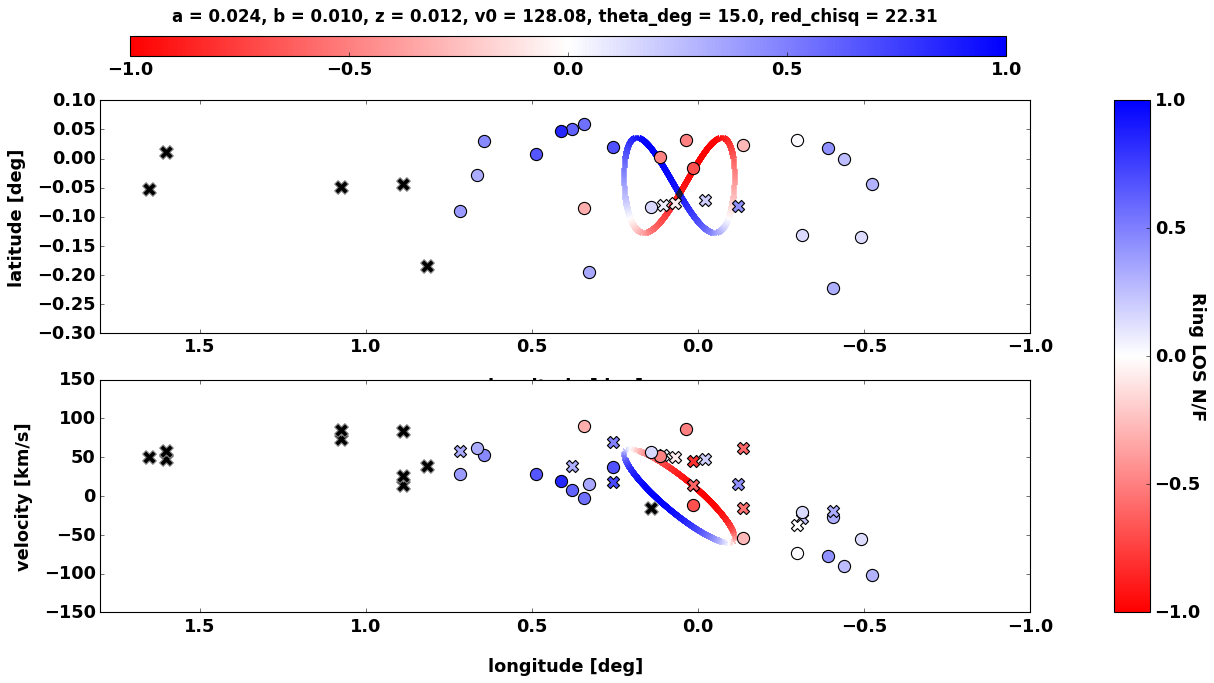

15 15


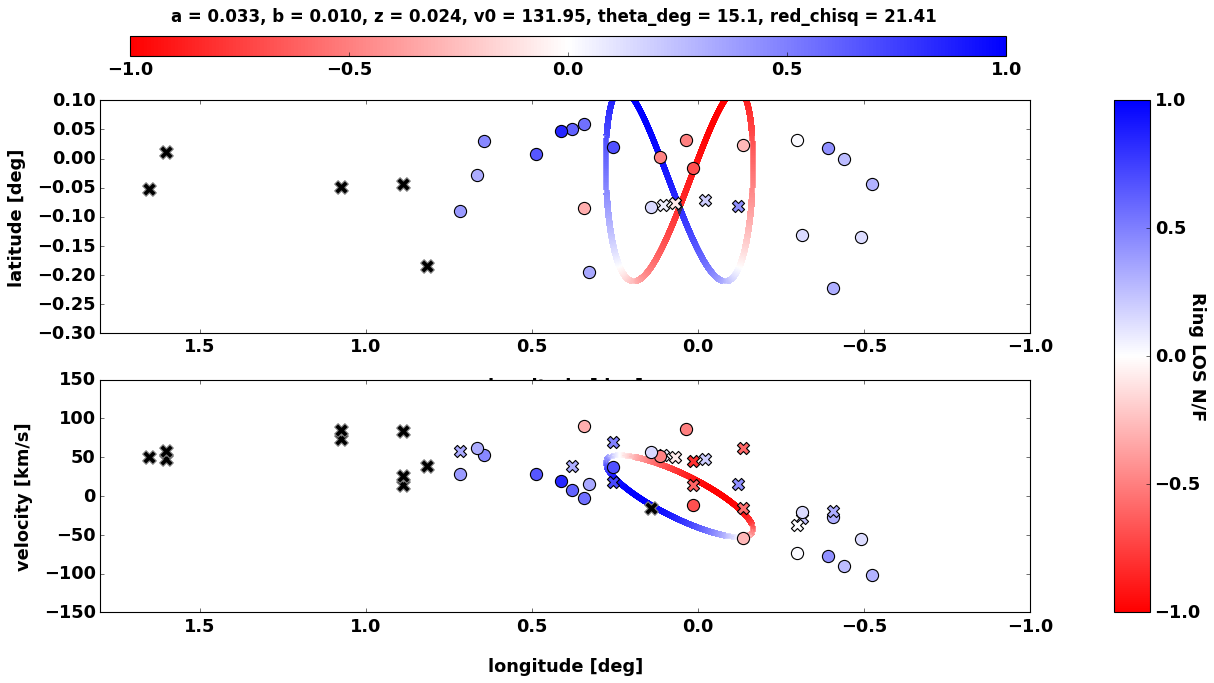

20 20


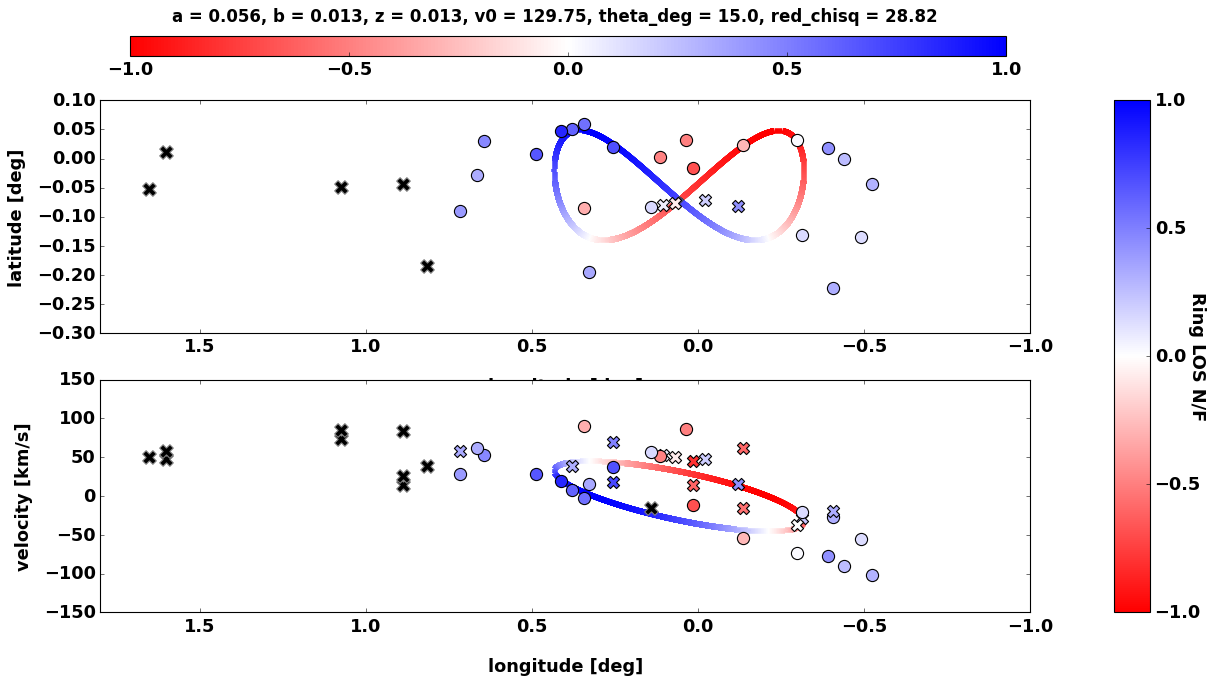

25 25


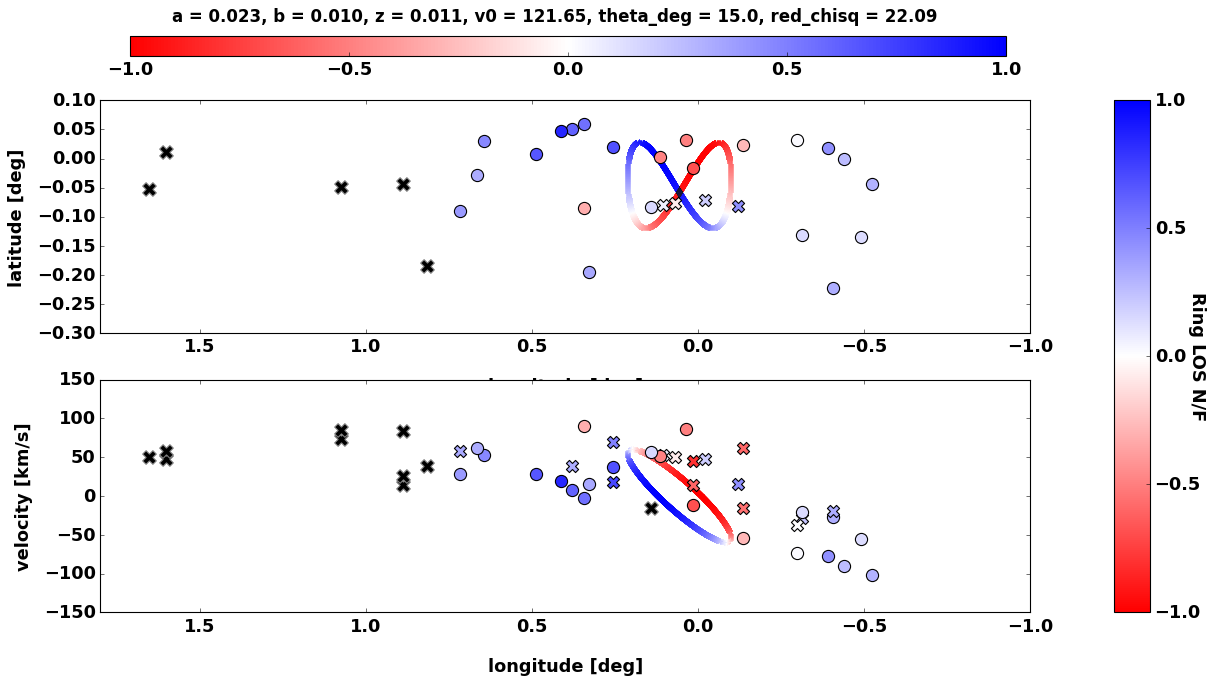

30 30


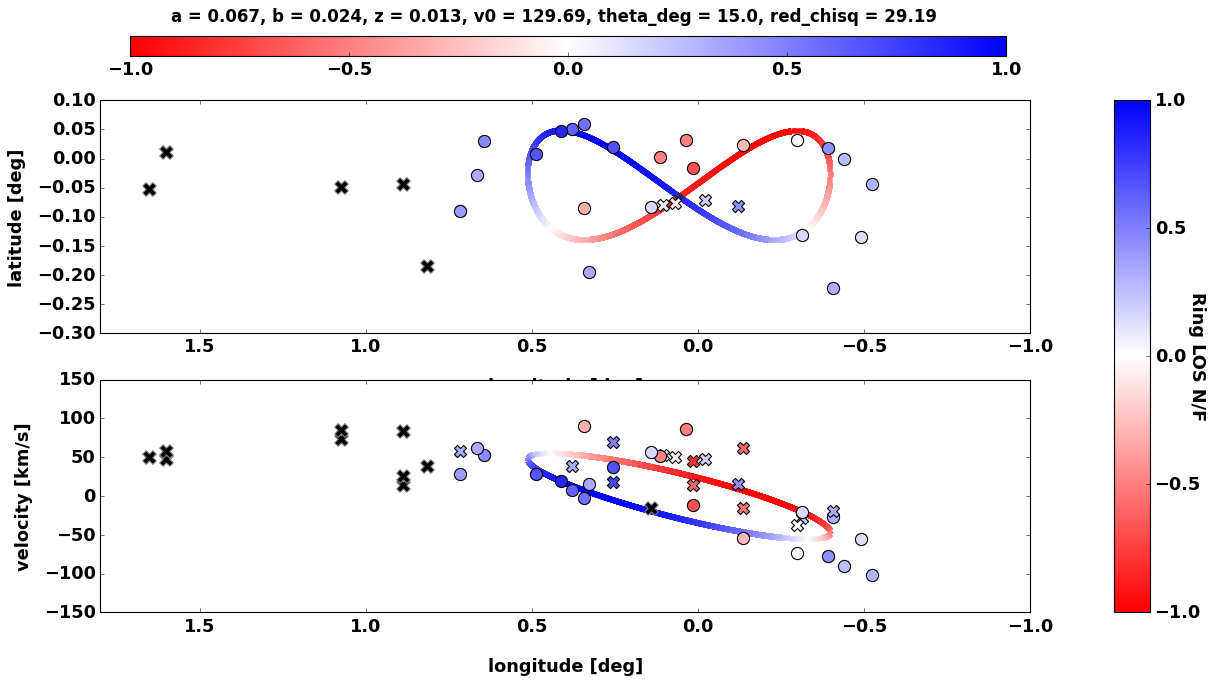

35 35


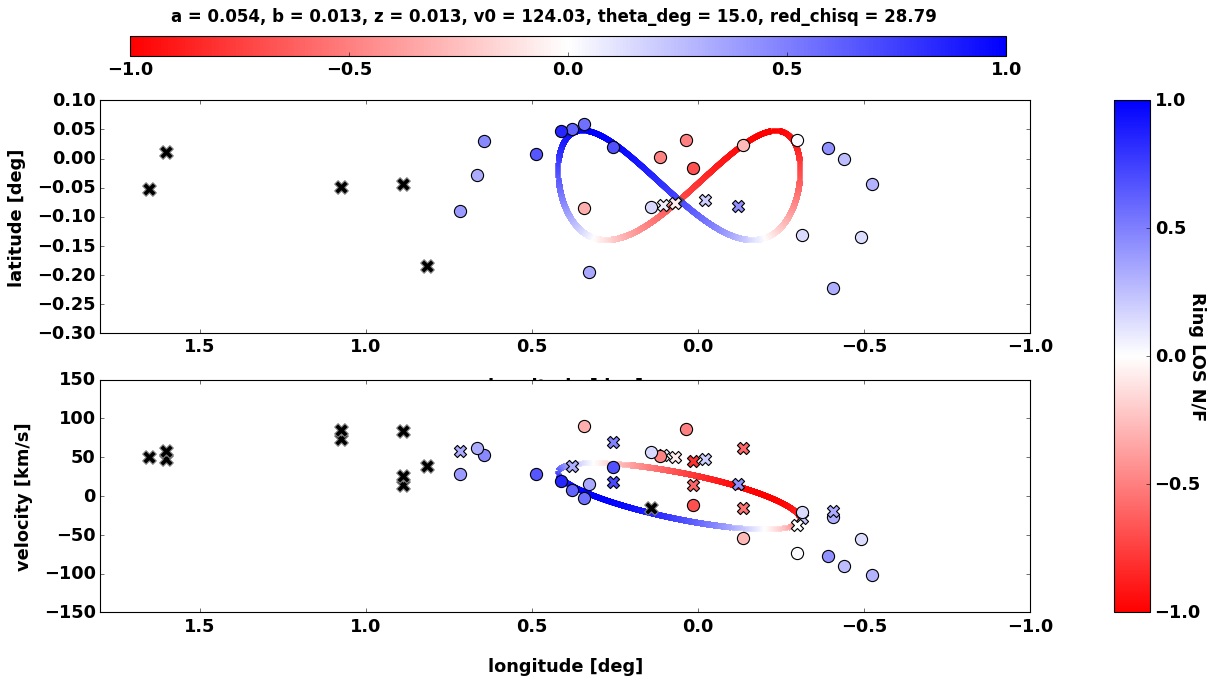

40 40


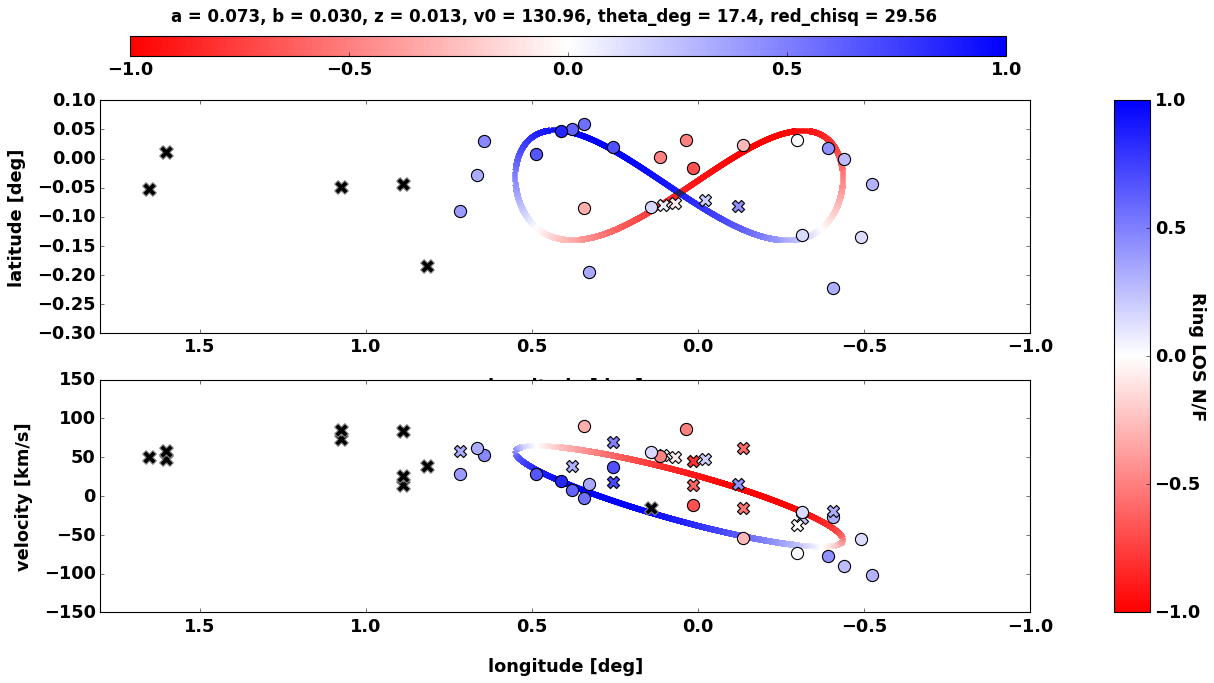

45 45


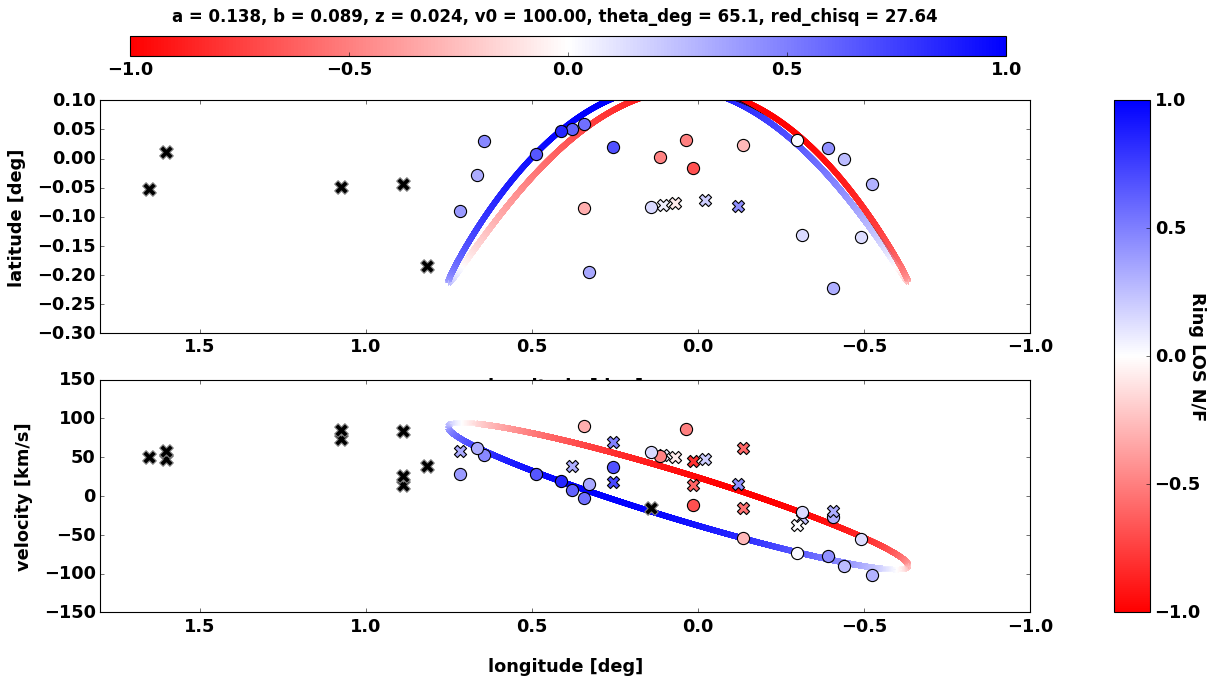

50 50


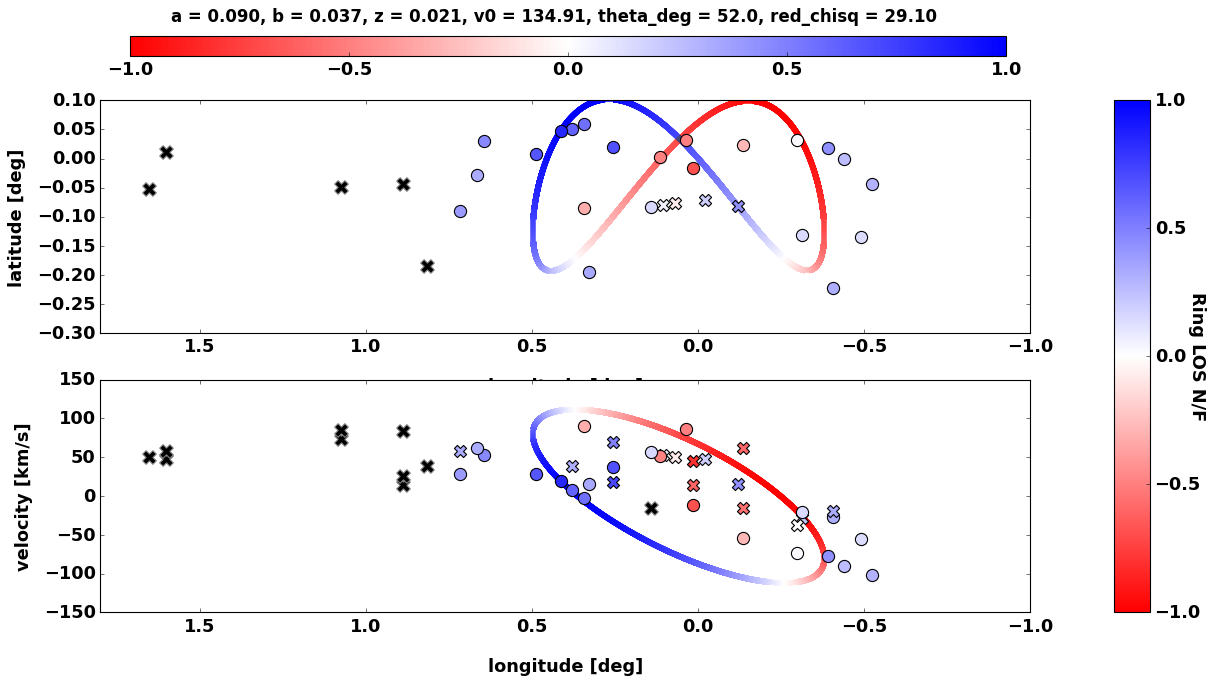

55 55


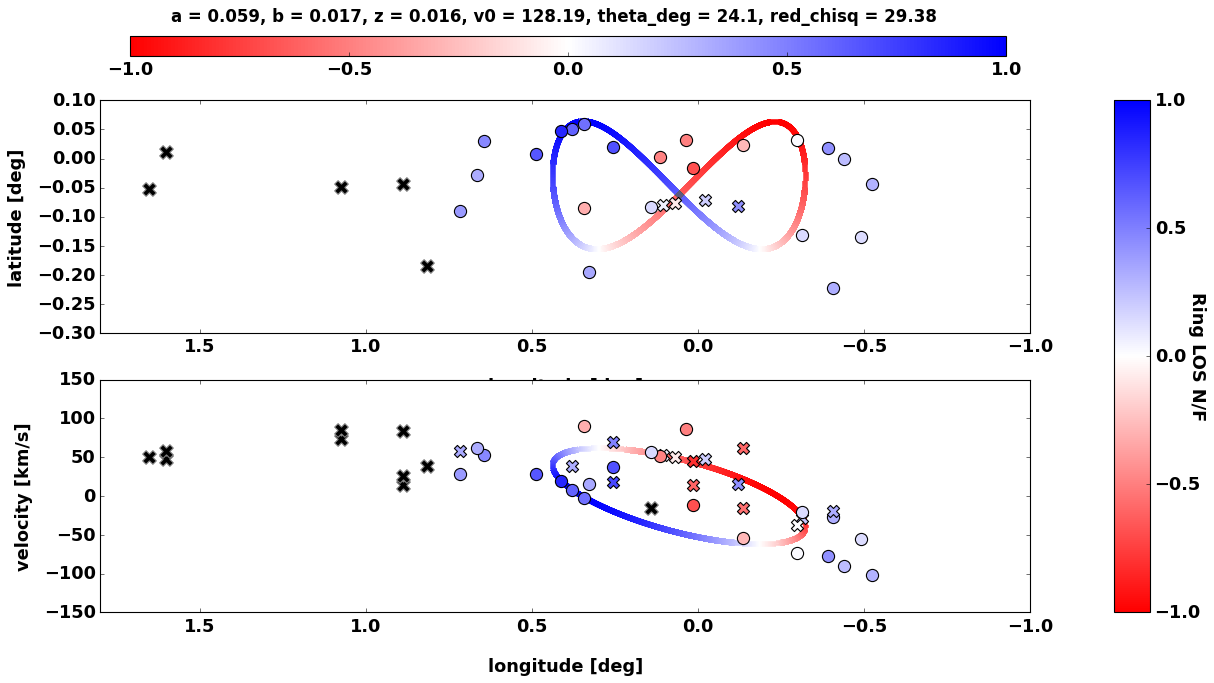

60 60


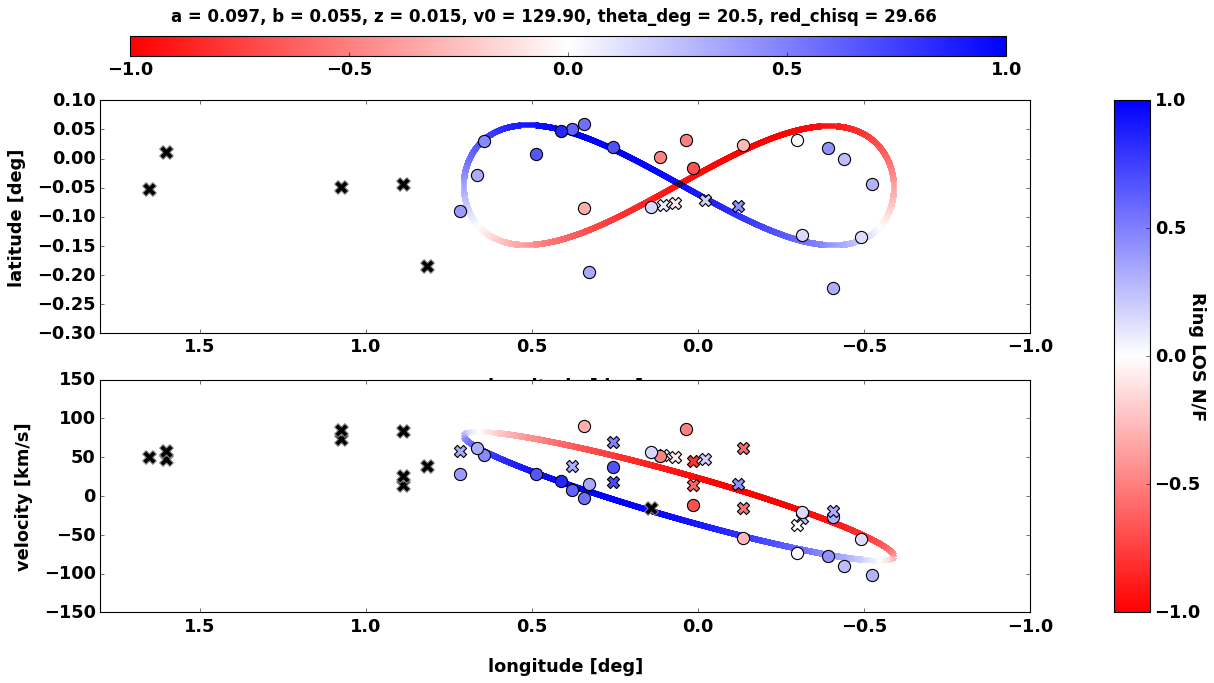

65 65


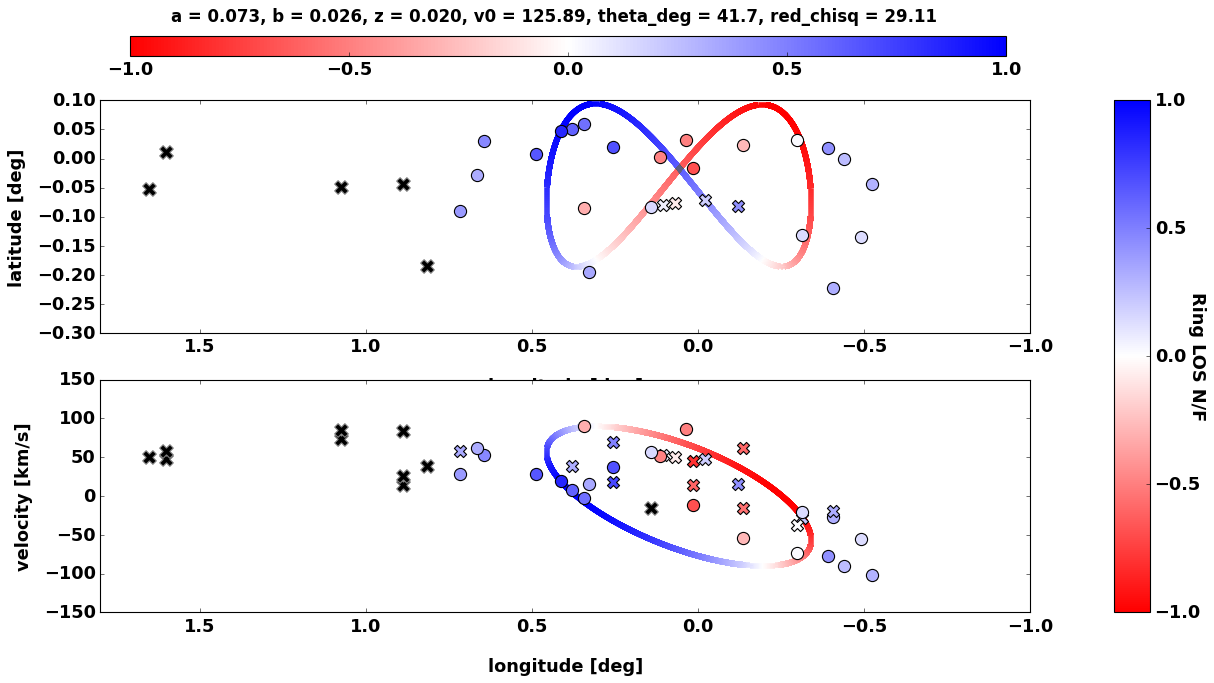

70 70


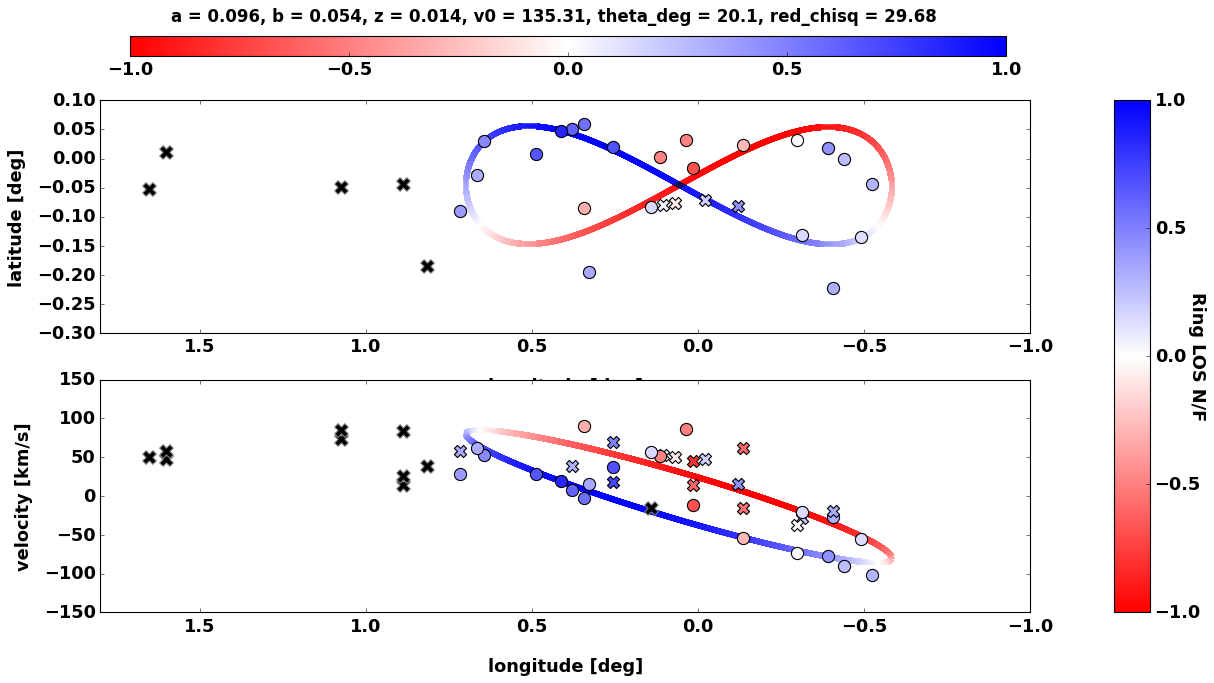

75 75


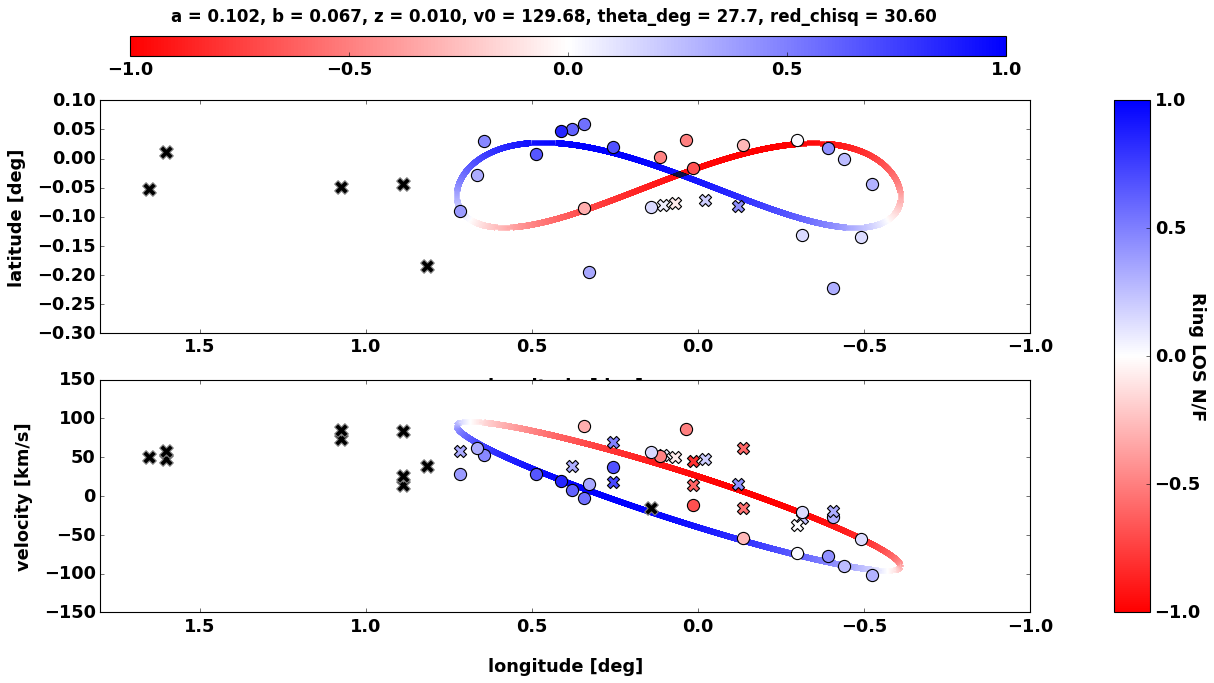

80 80


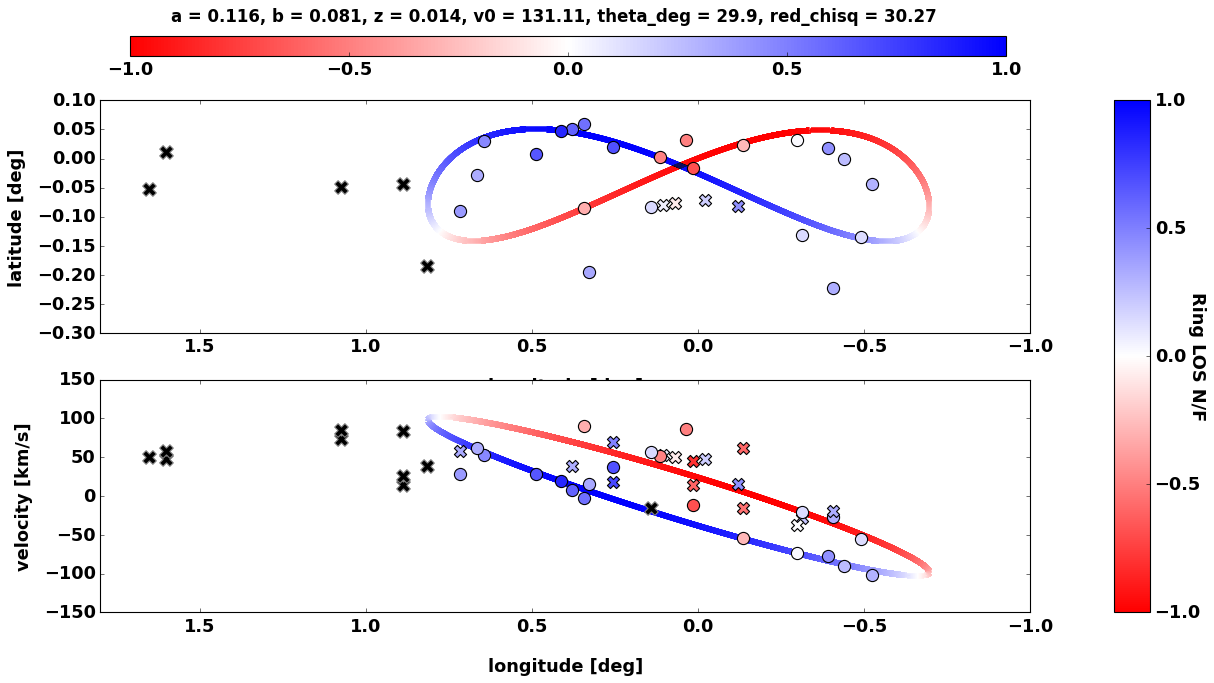

85 85


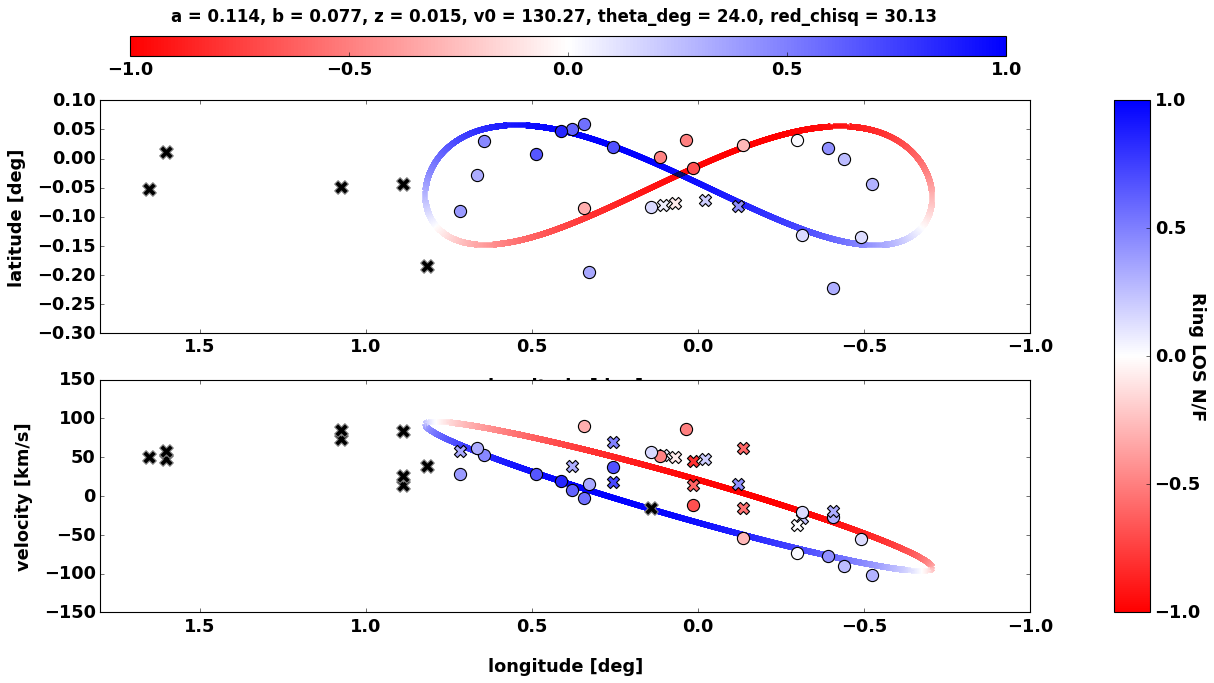

90 90


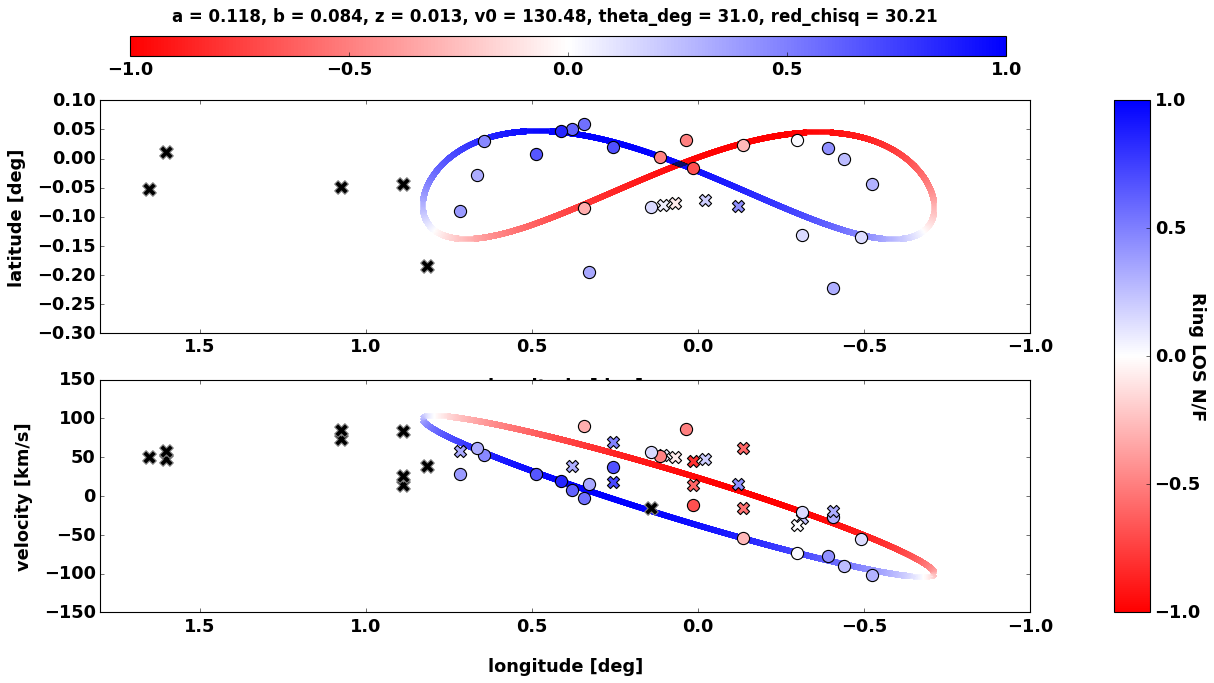

95 95


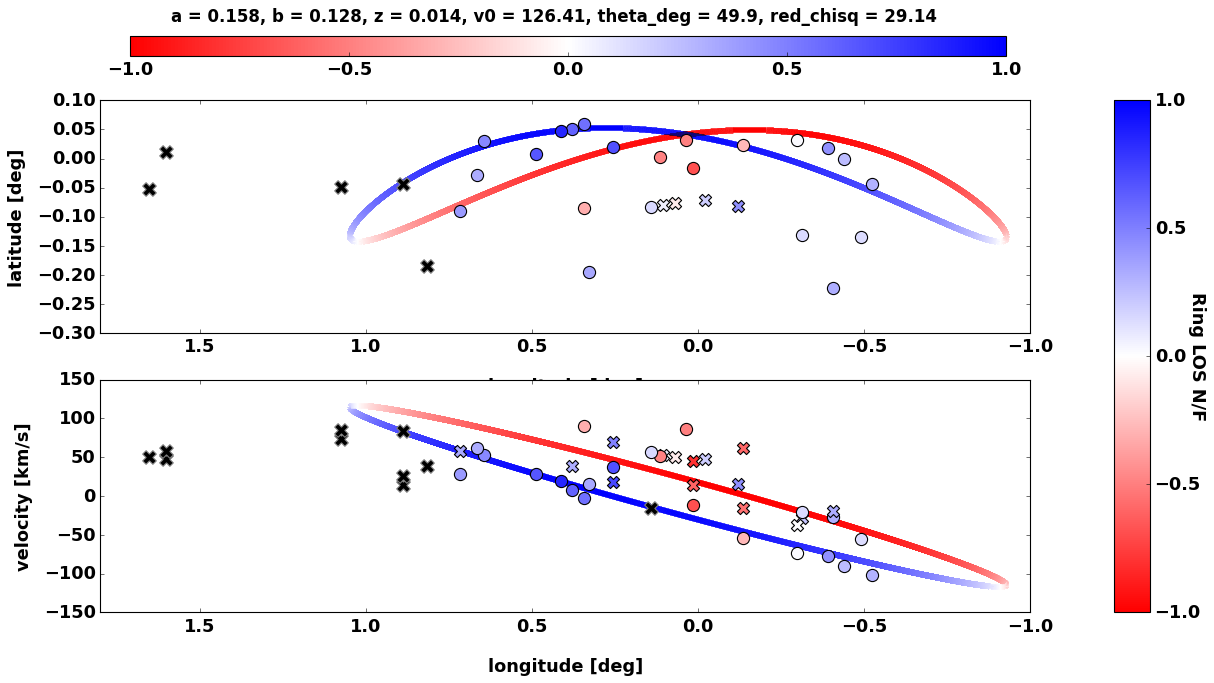

100 100


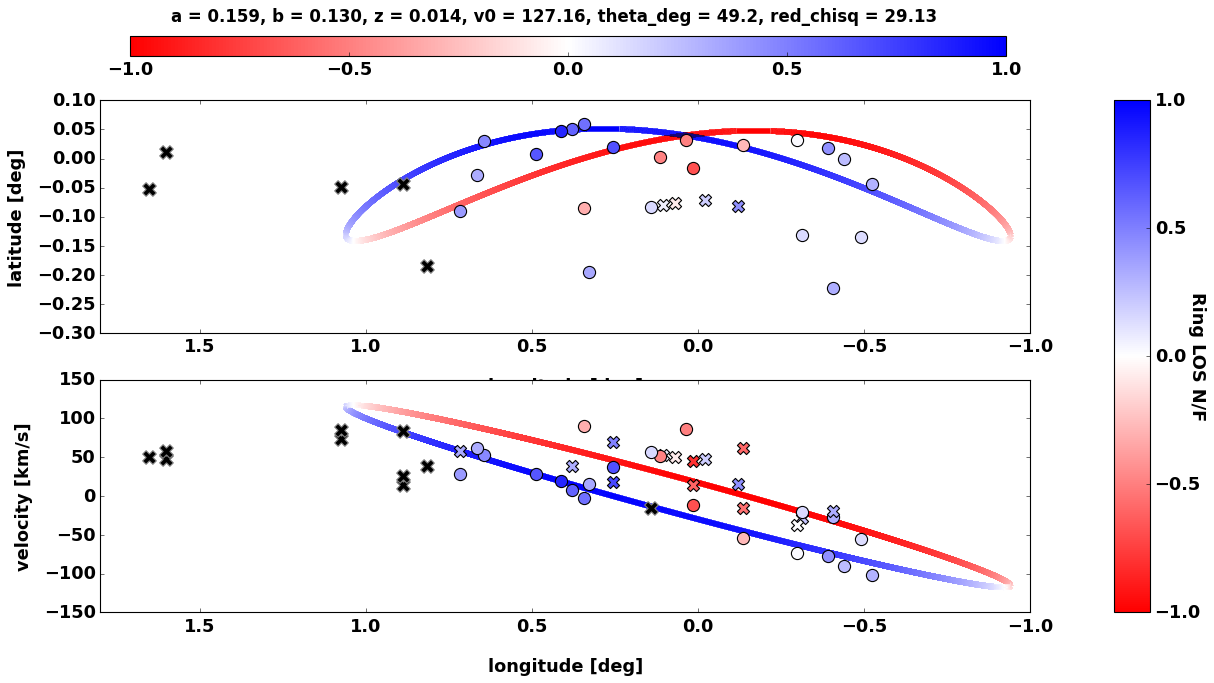

105 105


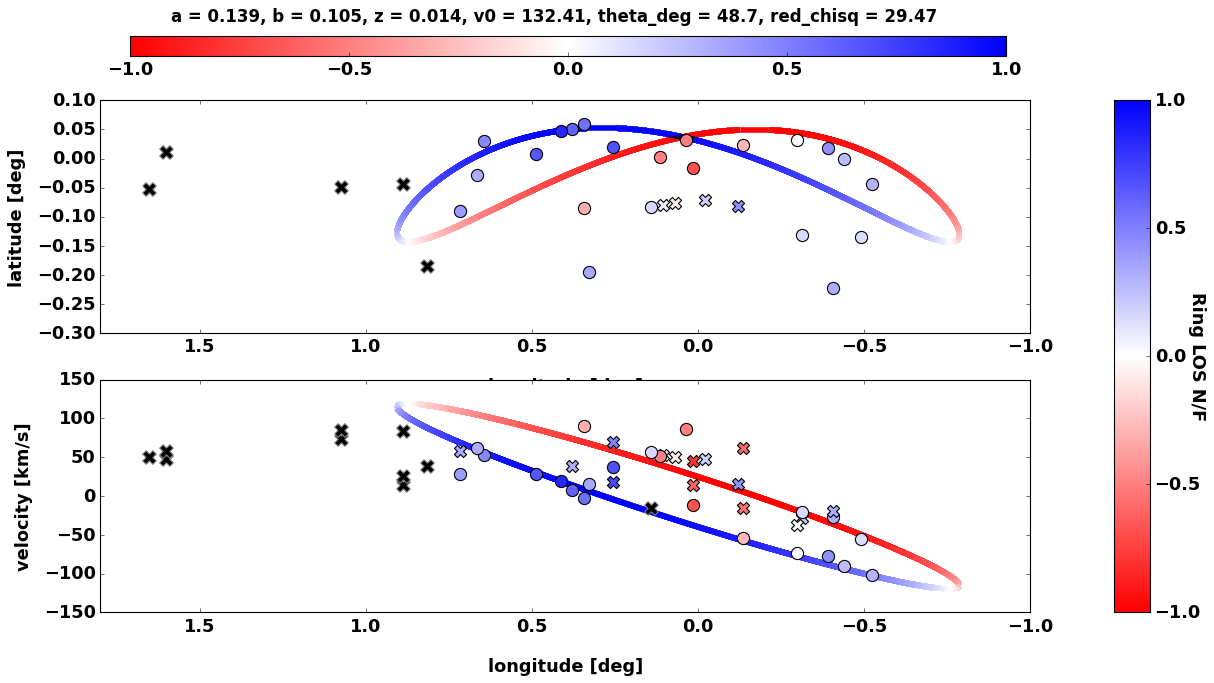

110 110


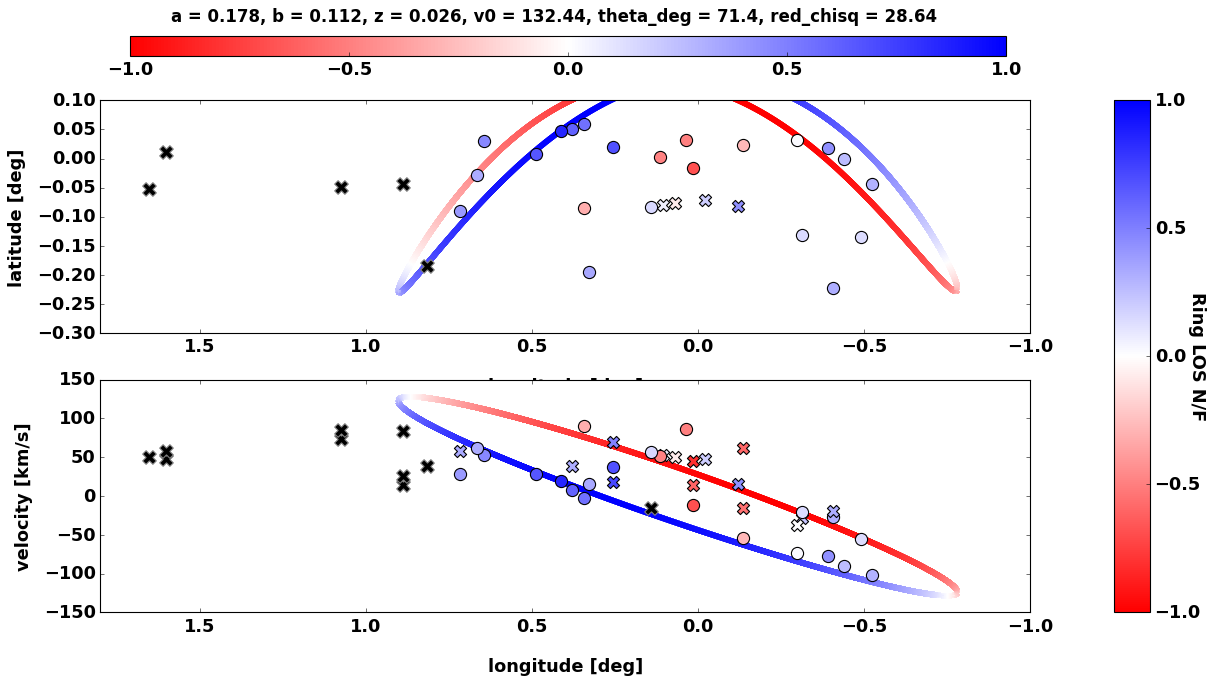

115 115


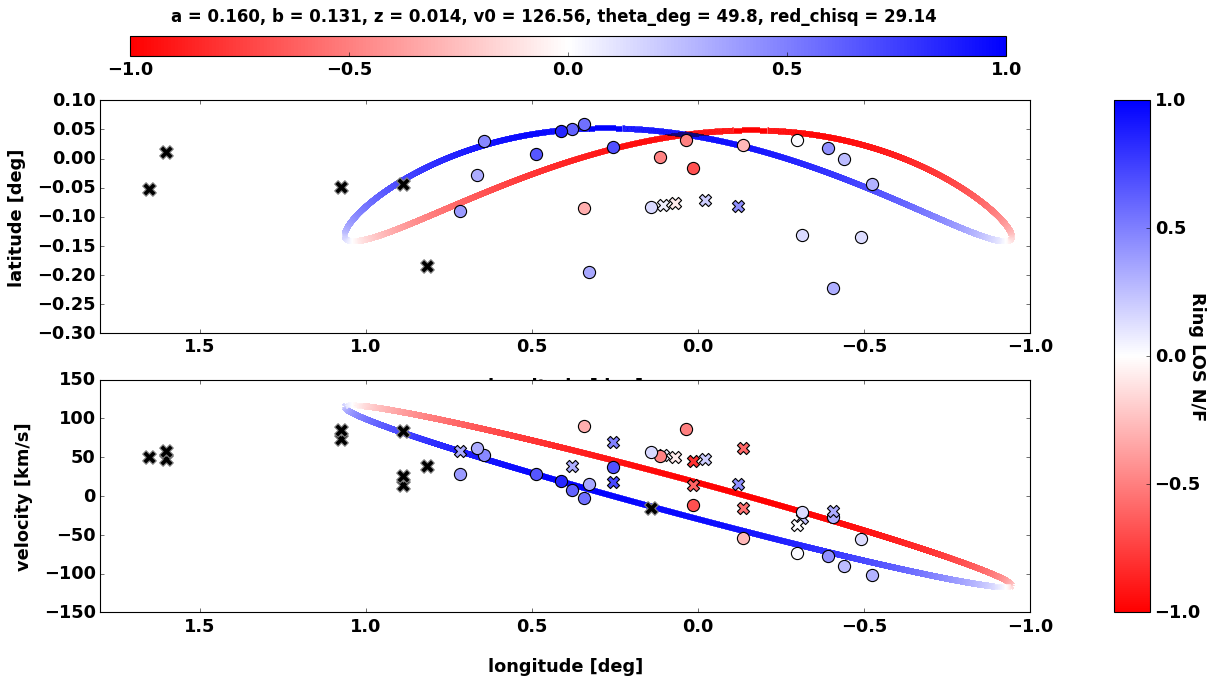

120 120


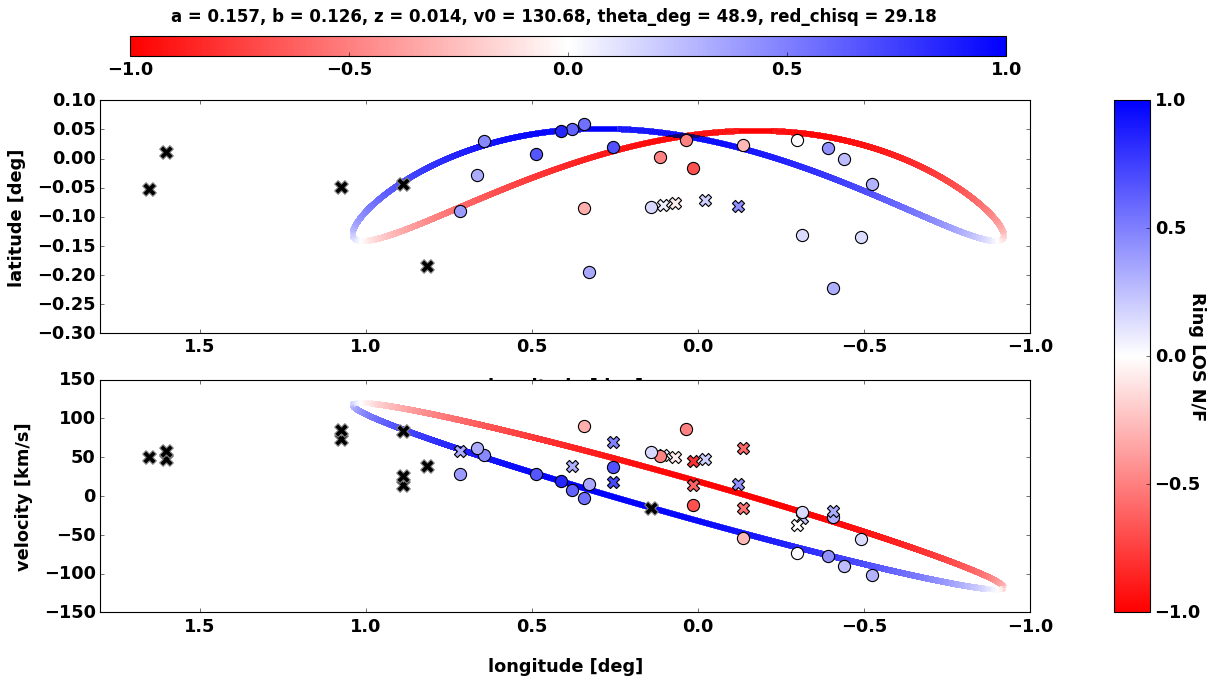

125 125


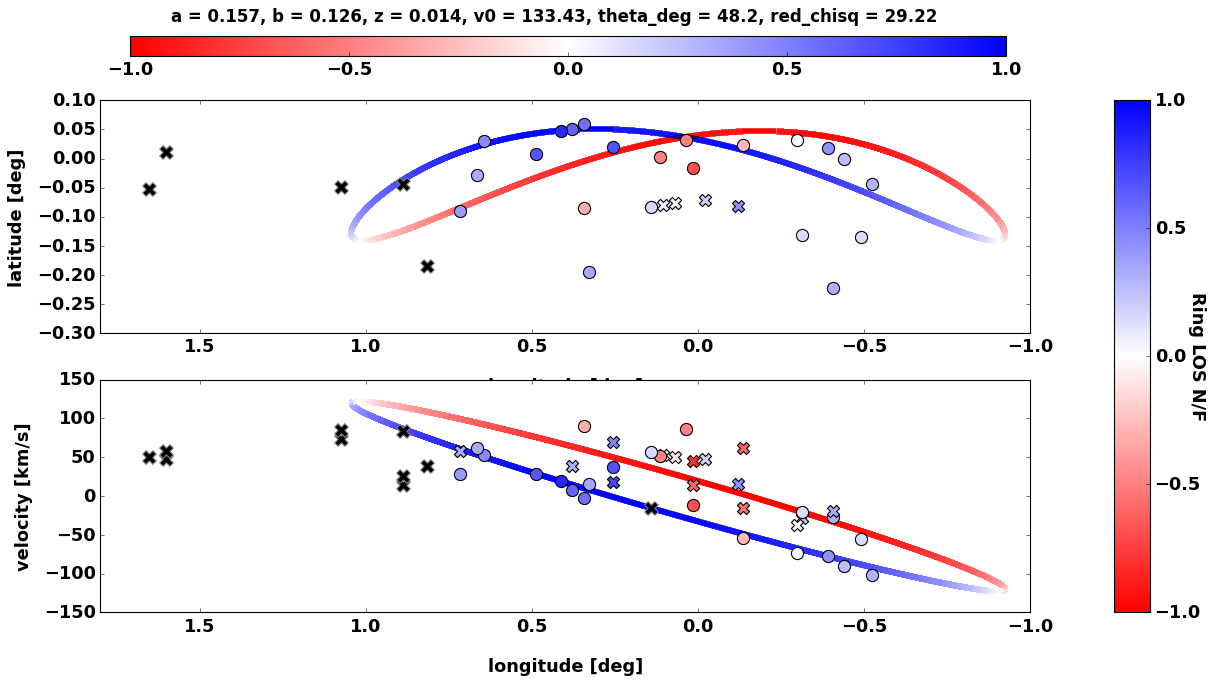

130 130


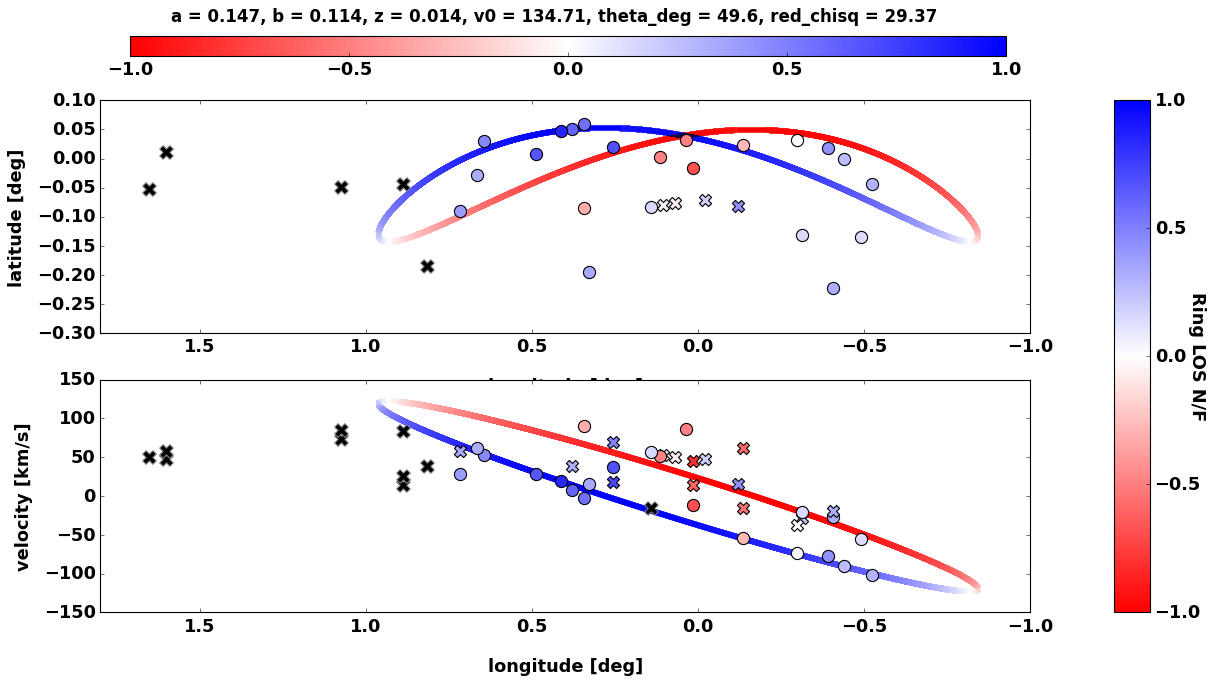

135 135


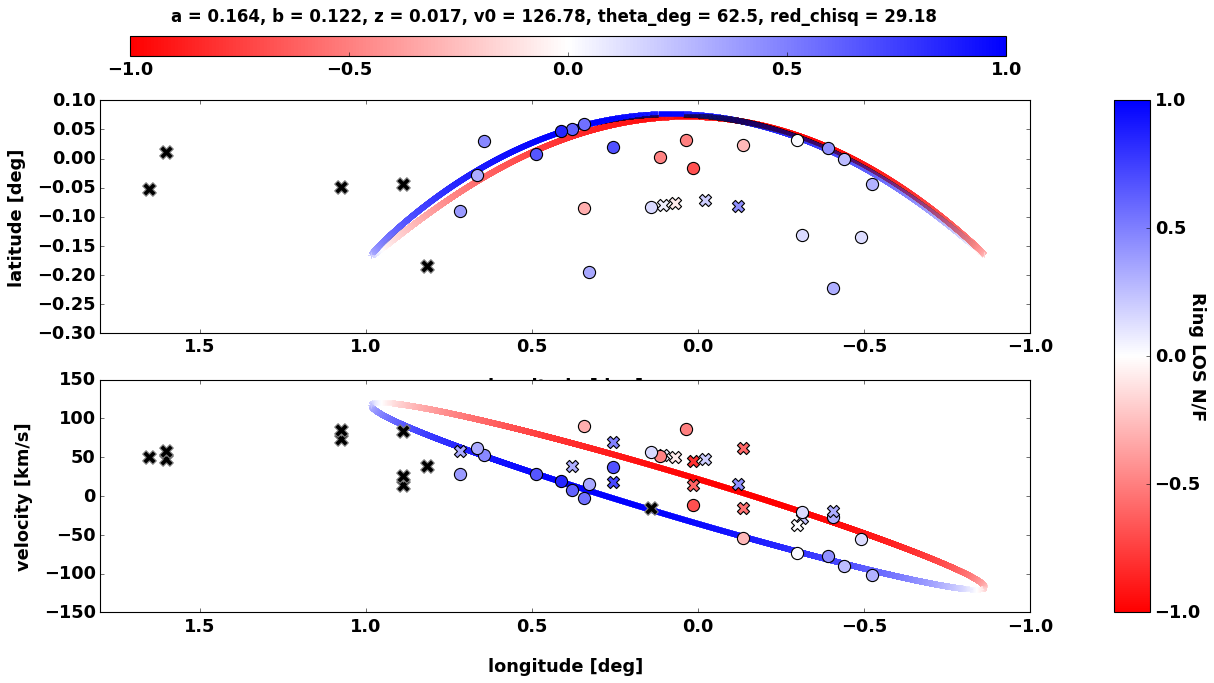

140 140


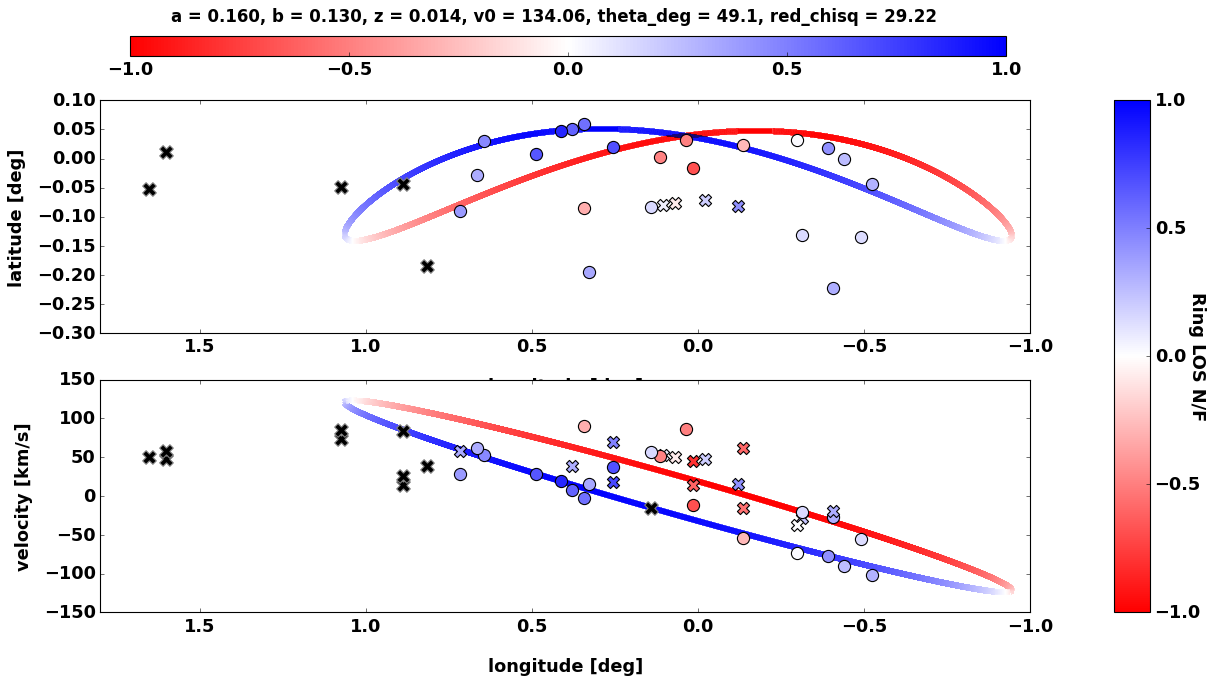

145 145


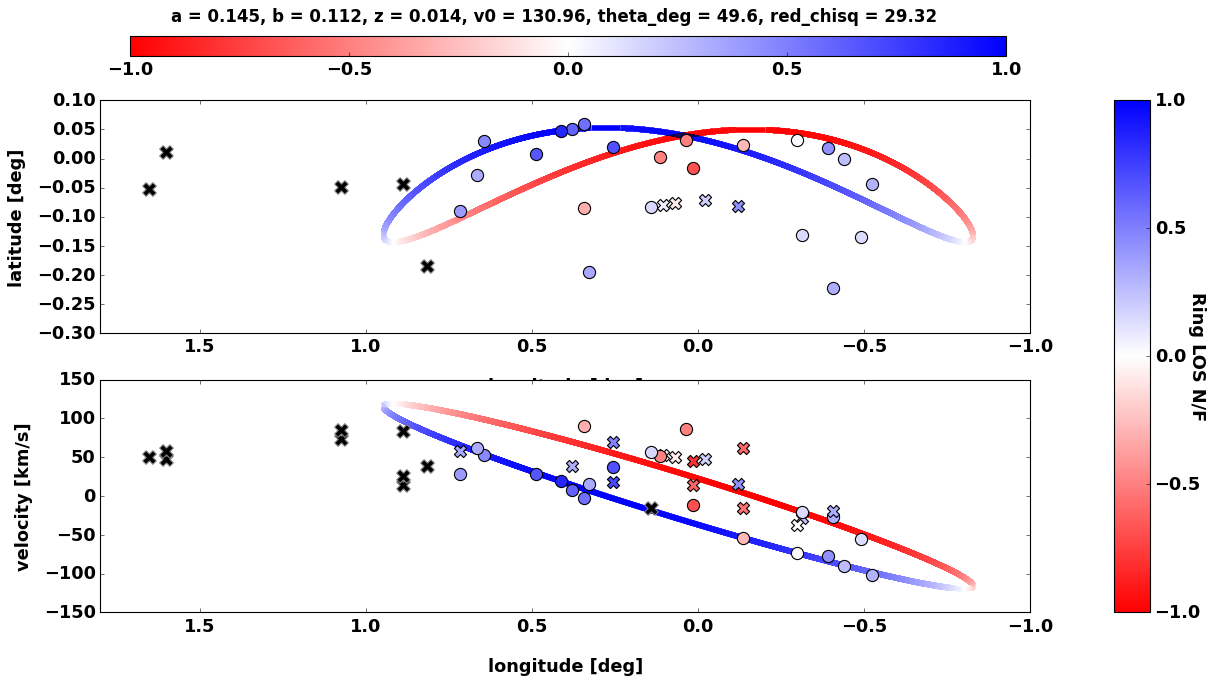

150 150


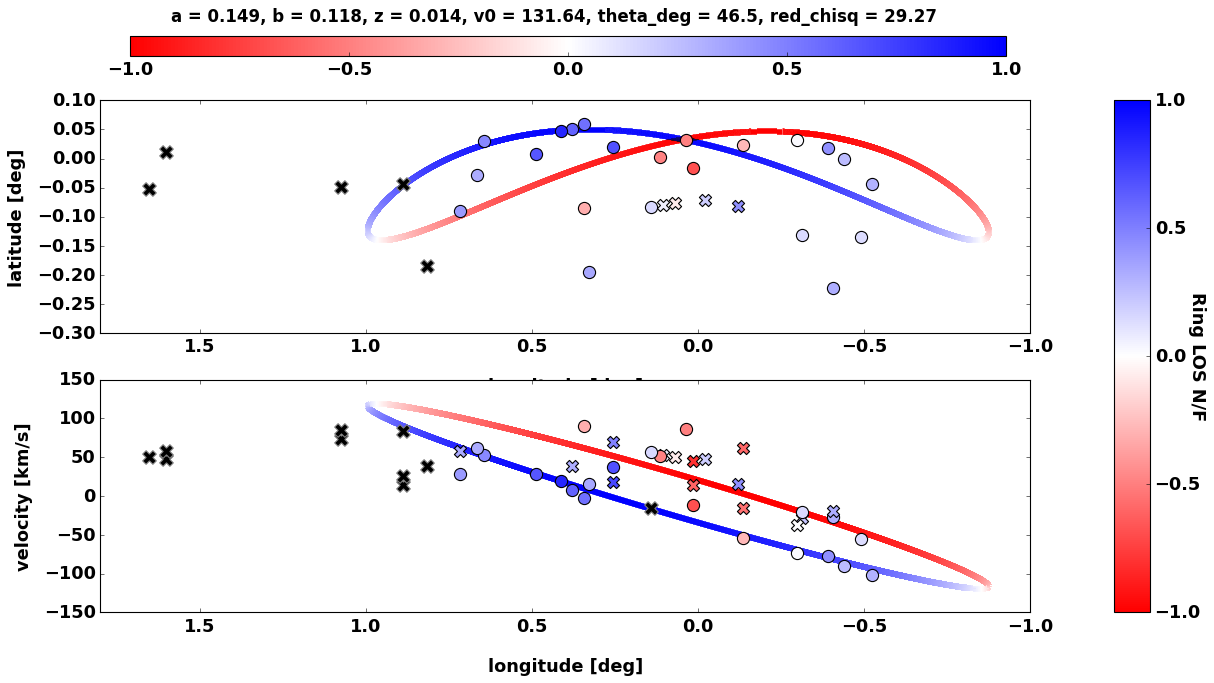

155 155


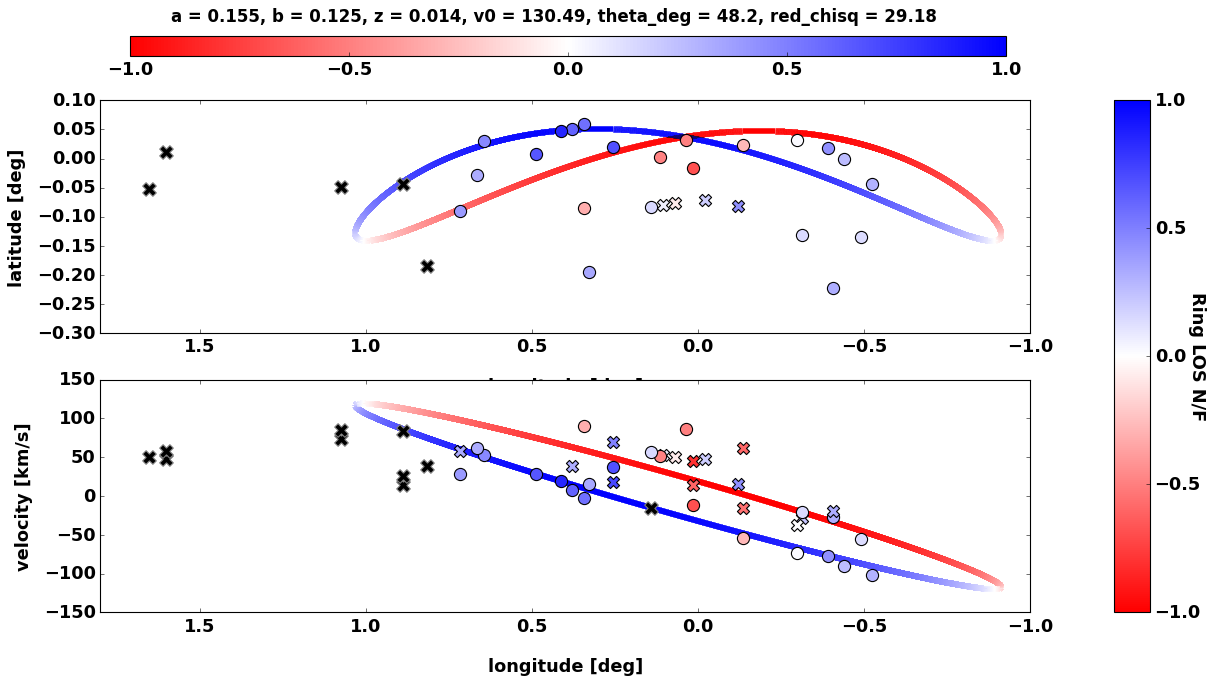

160 160


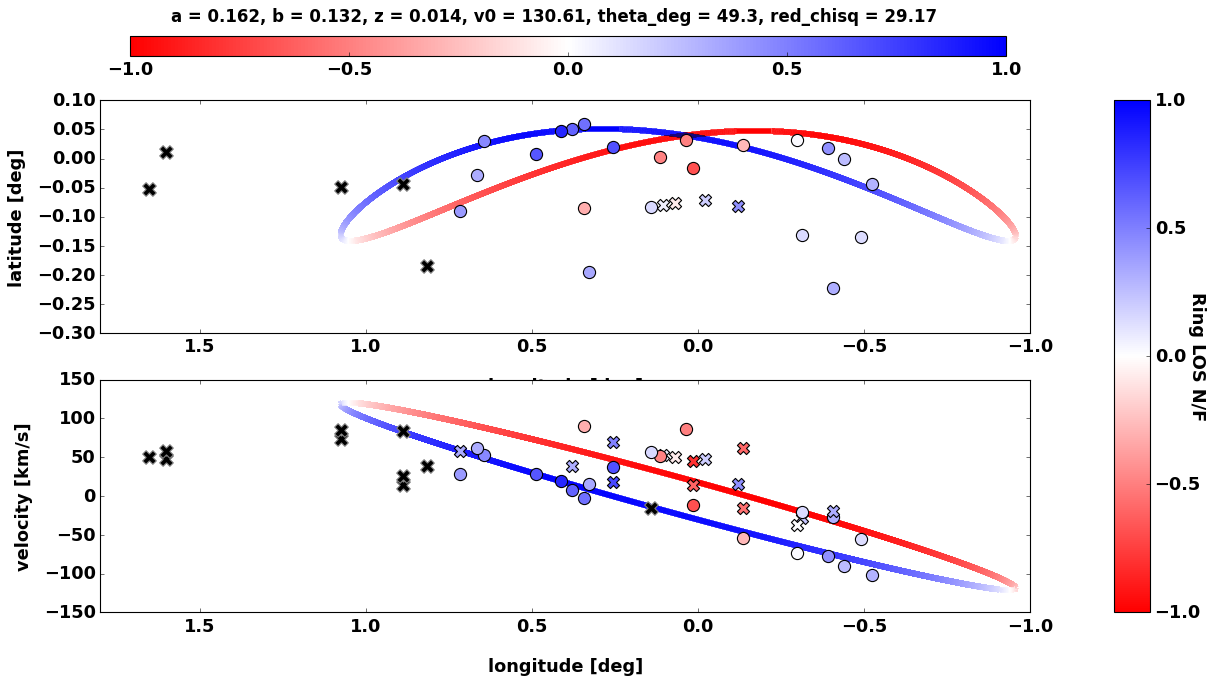

165 165


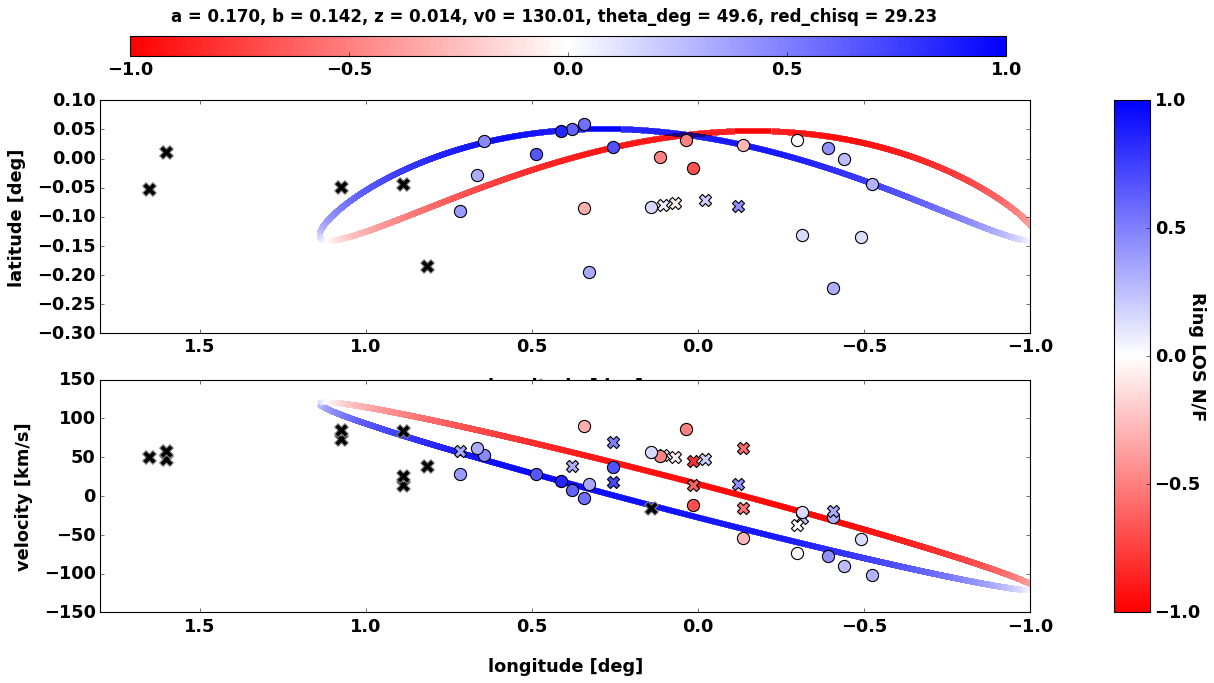

170 170


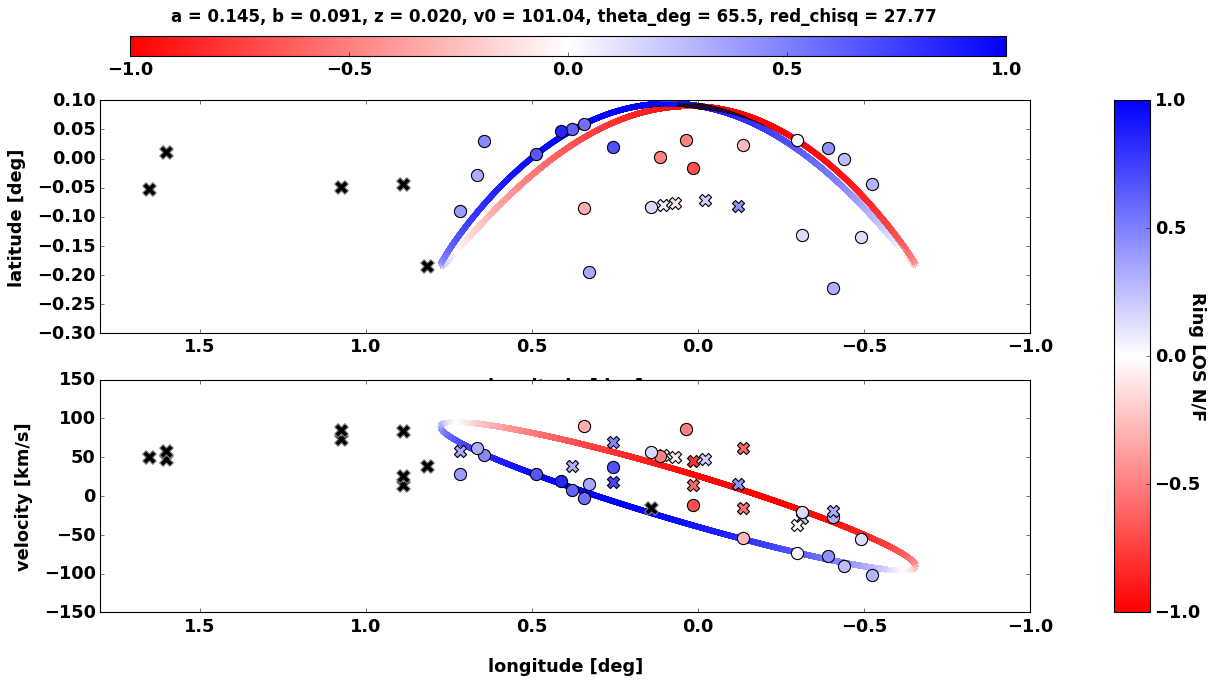

175 175


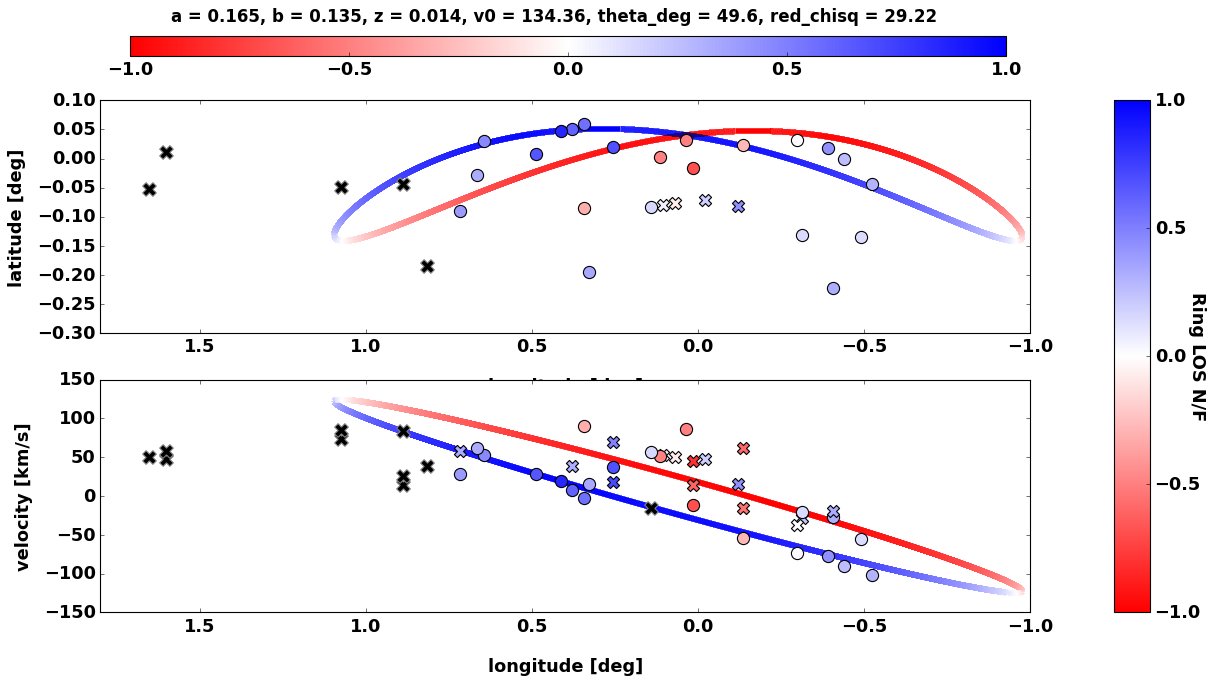

180 180


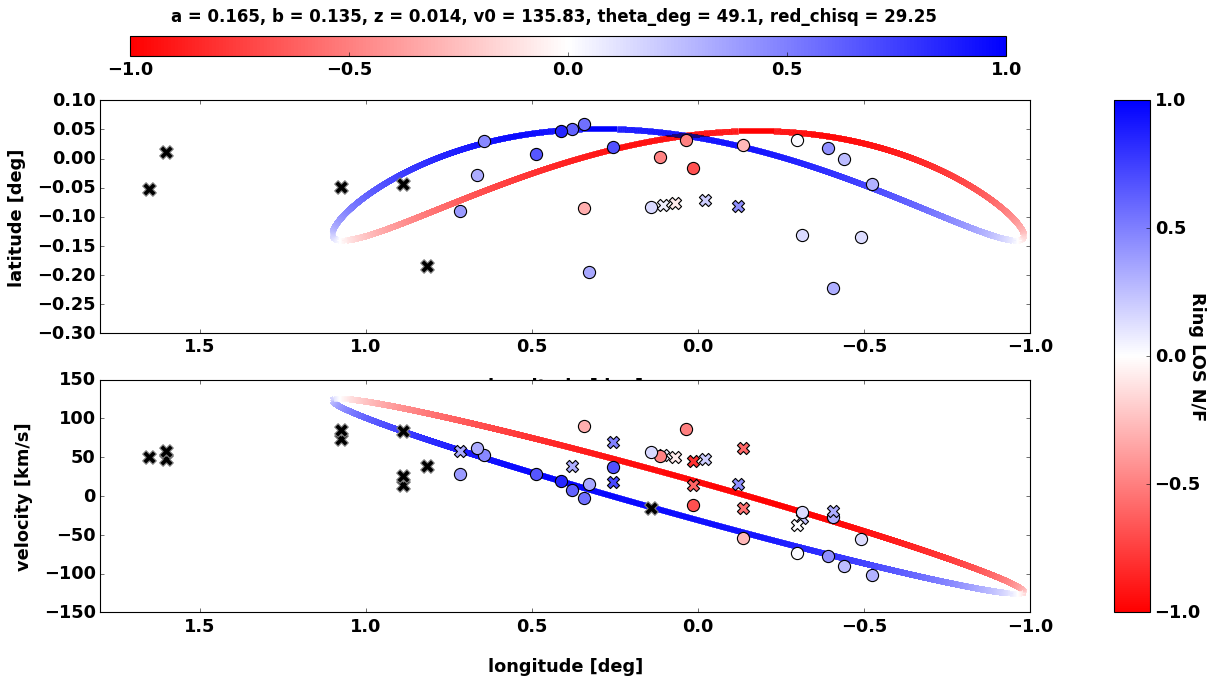

185 185


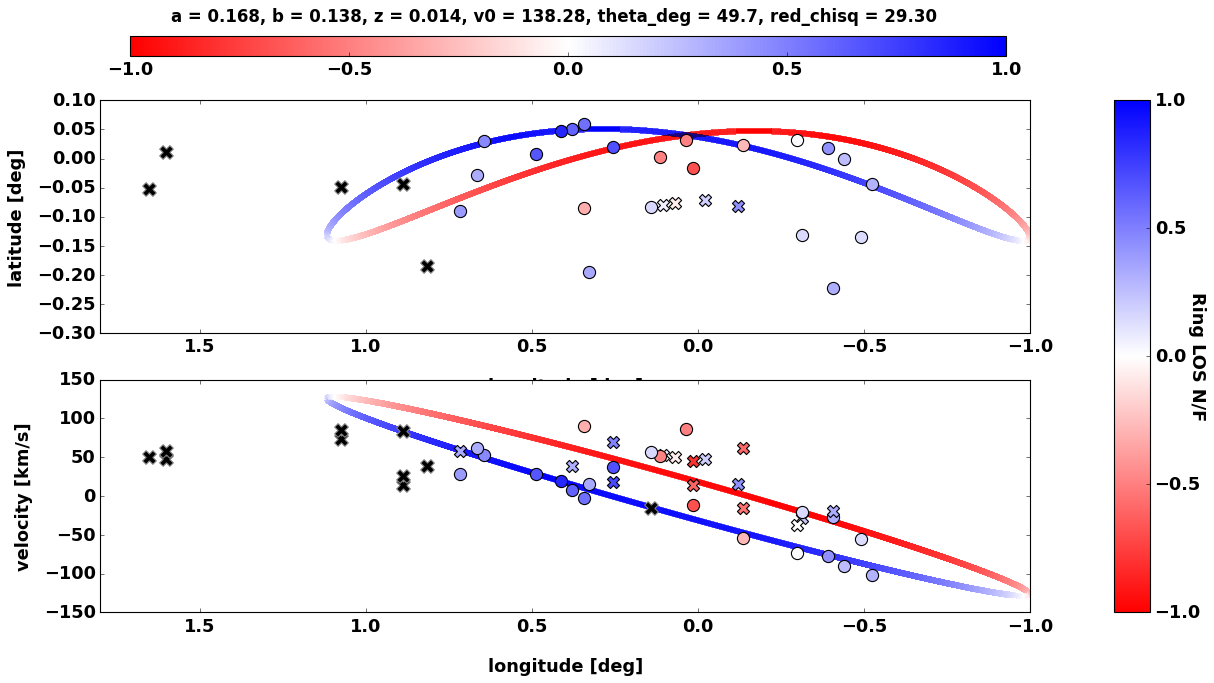

190 190


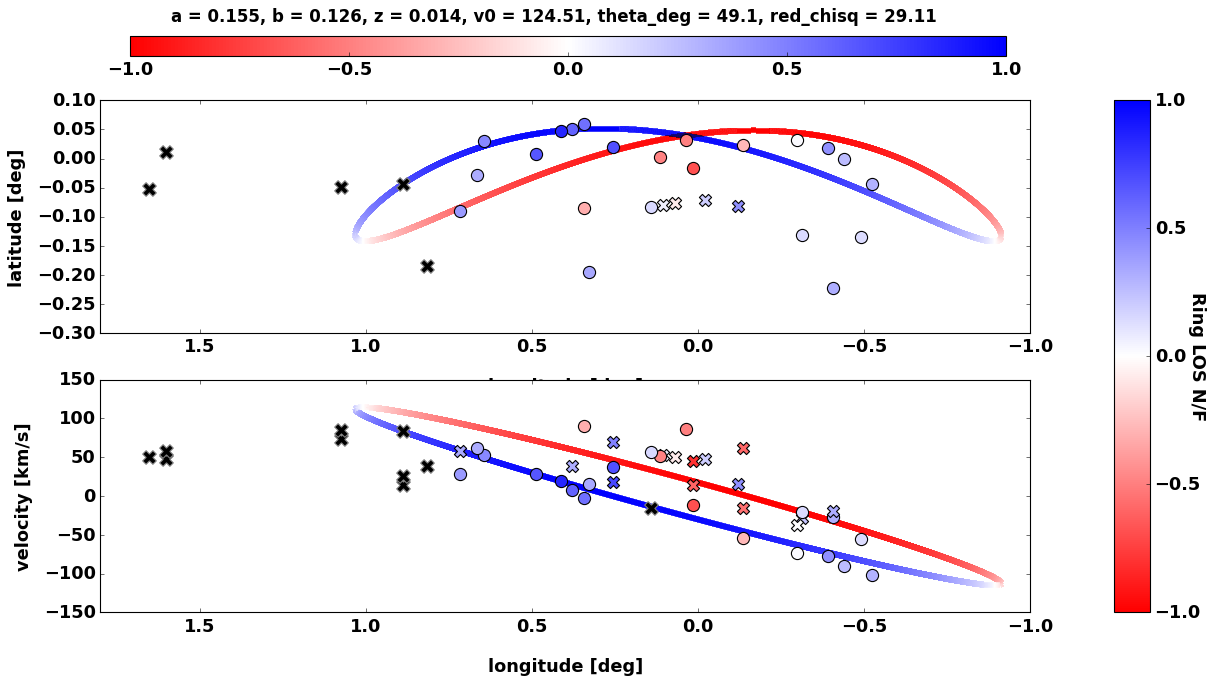

195 195


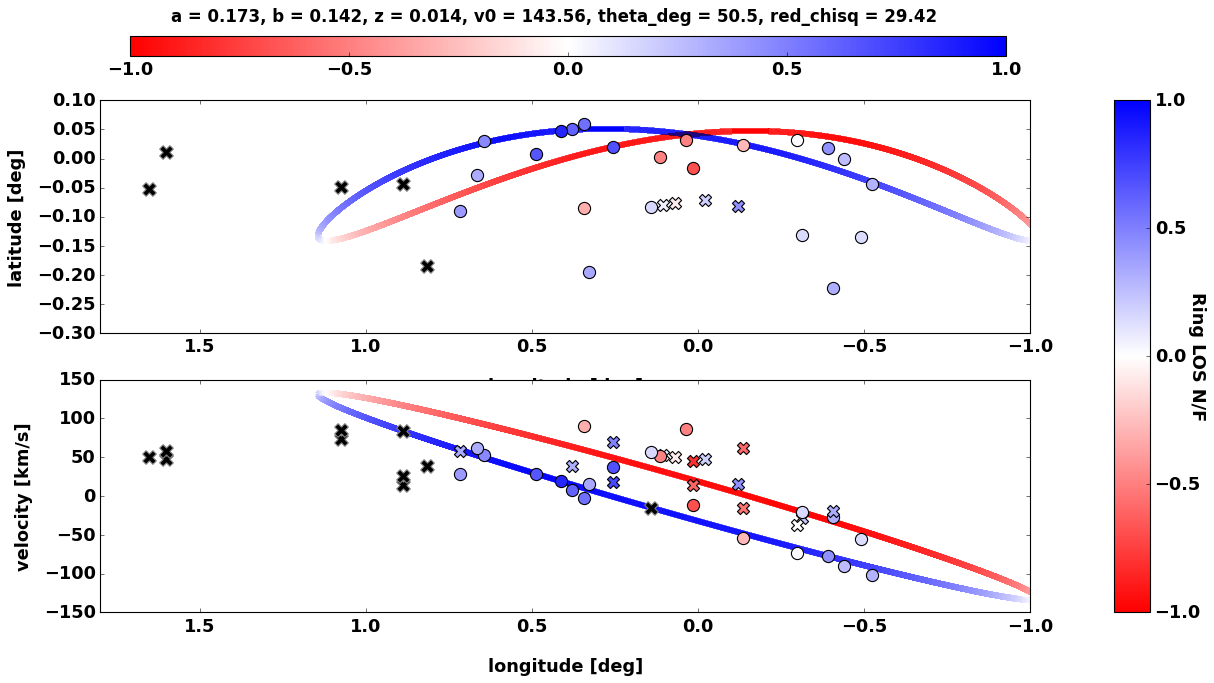

200 200


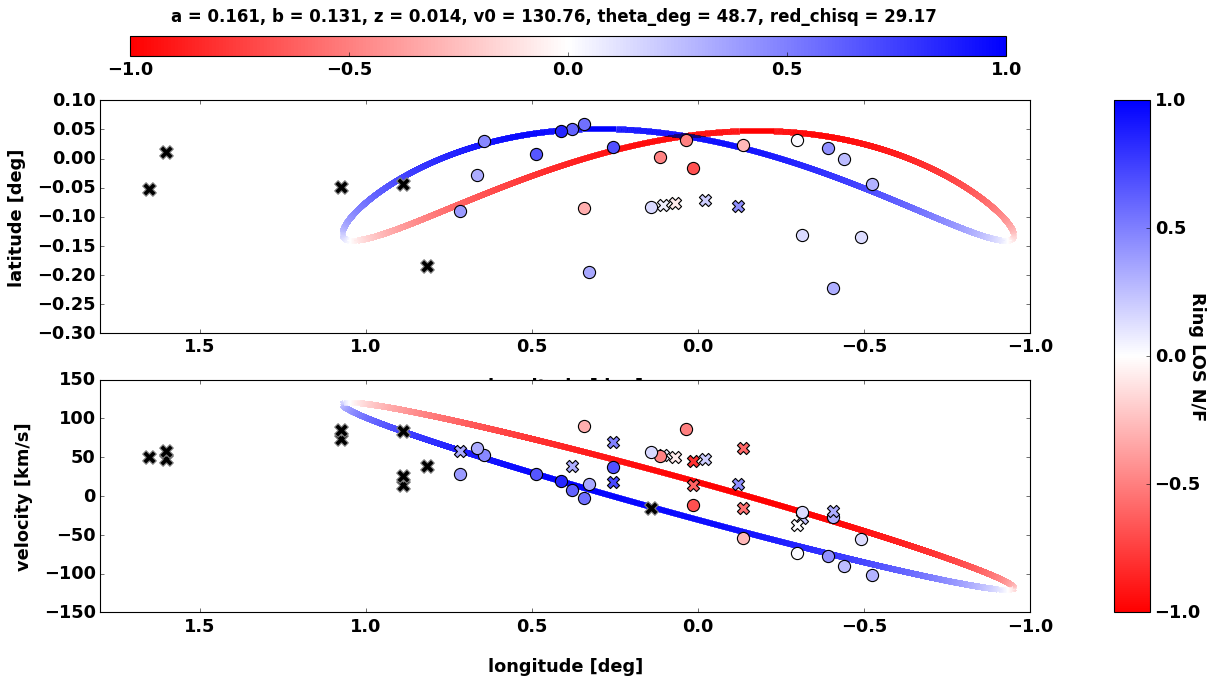

205 205


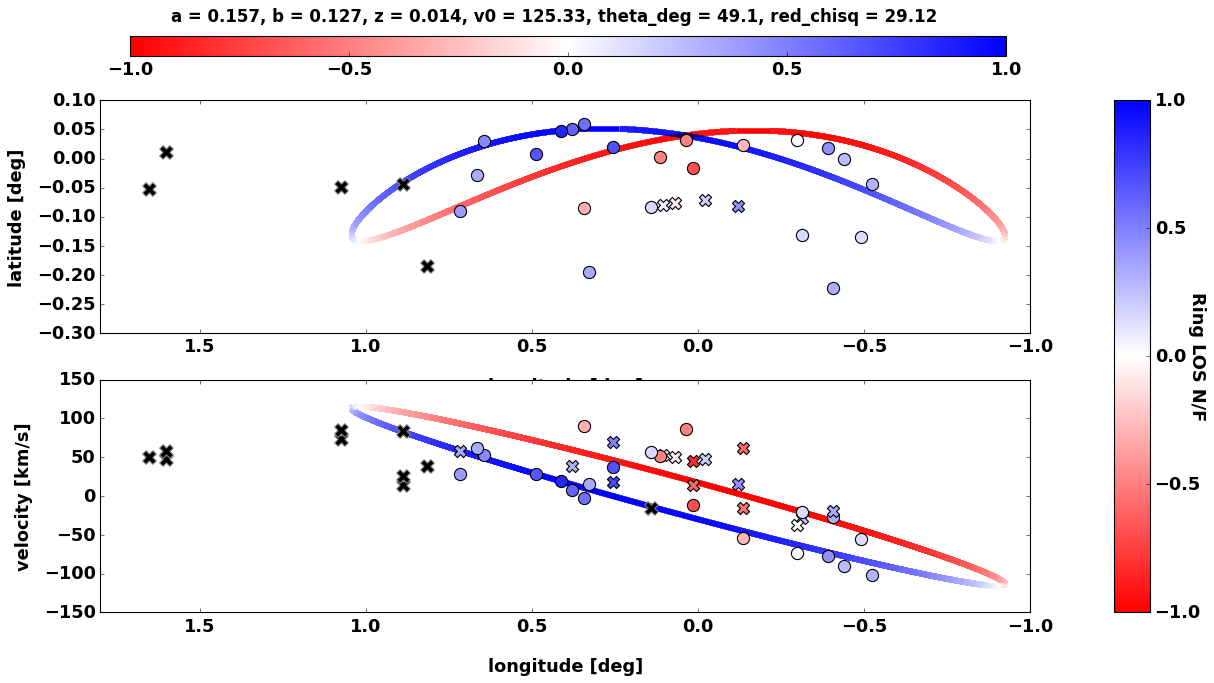

210 210


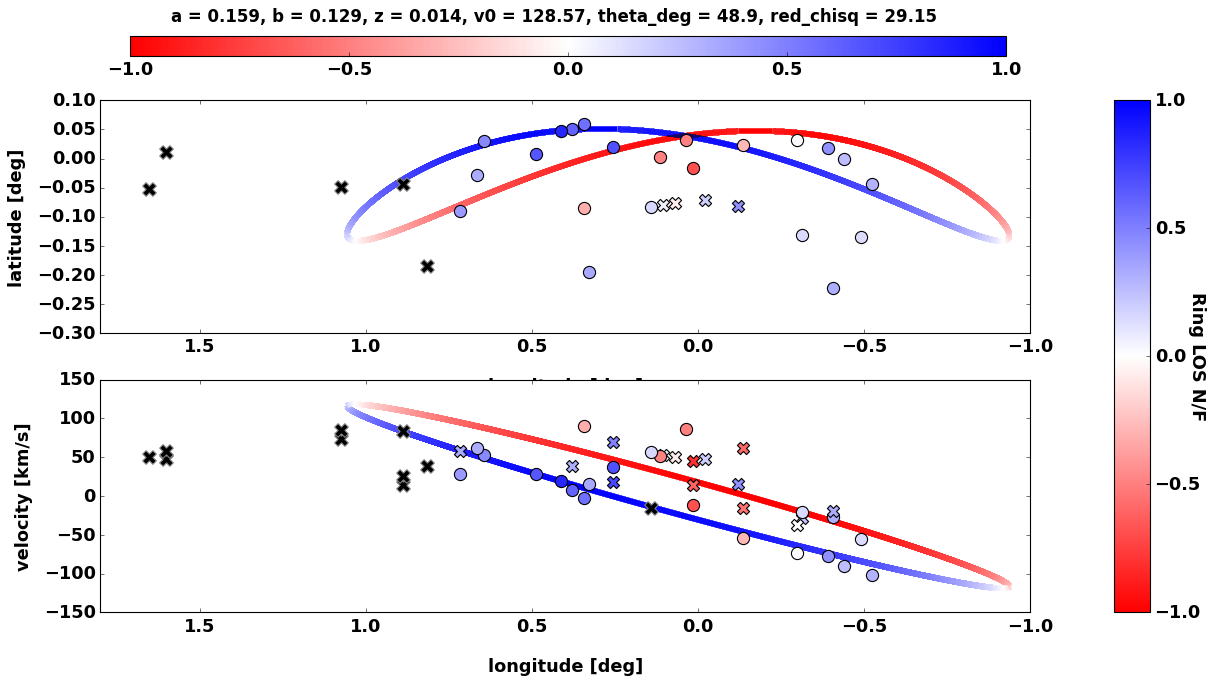

215 215


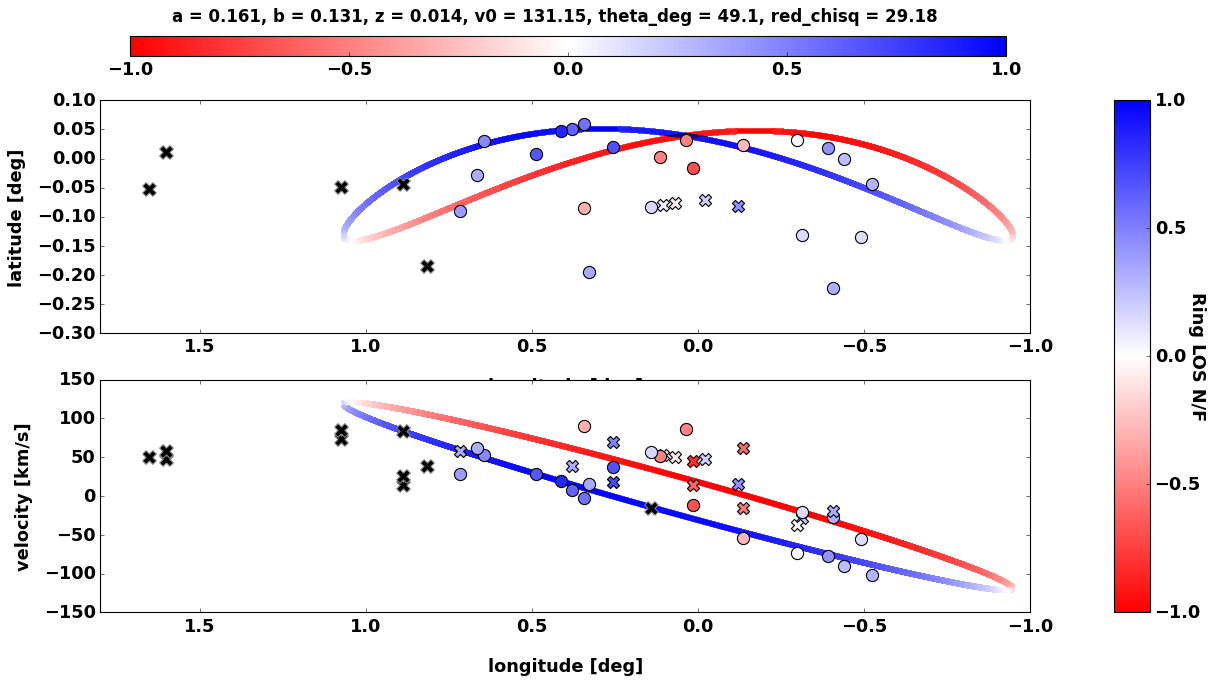

220 220


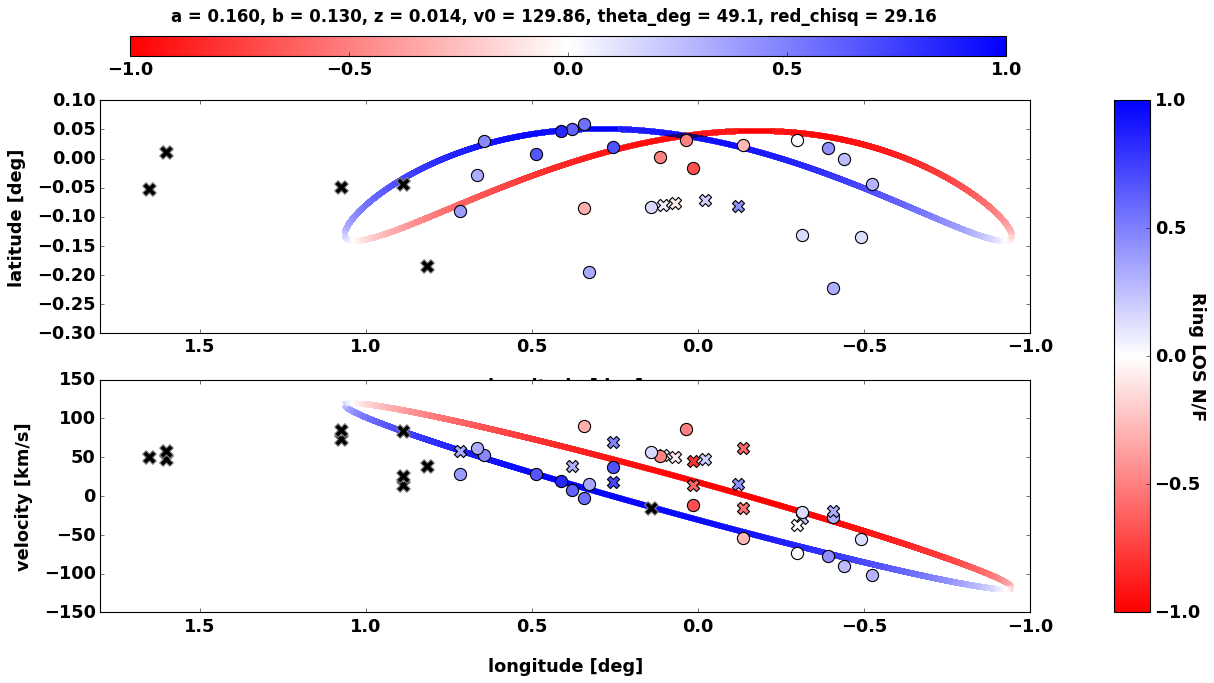

225 225


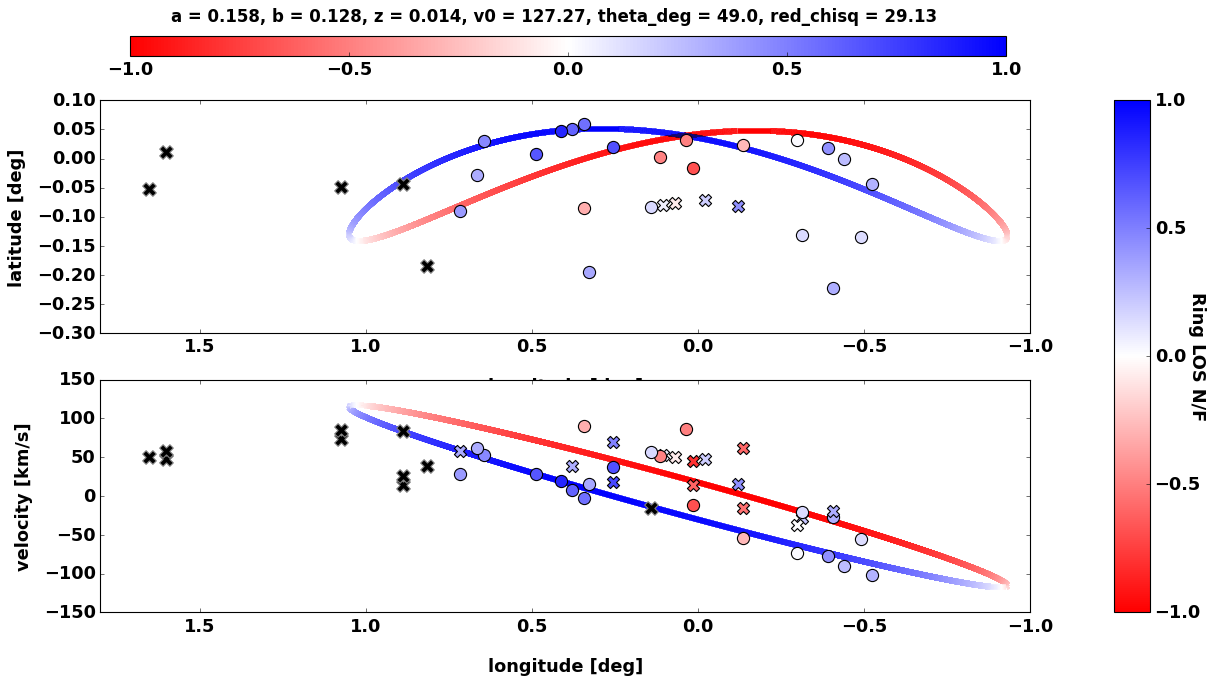

230 230


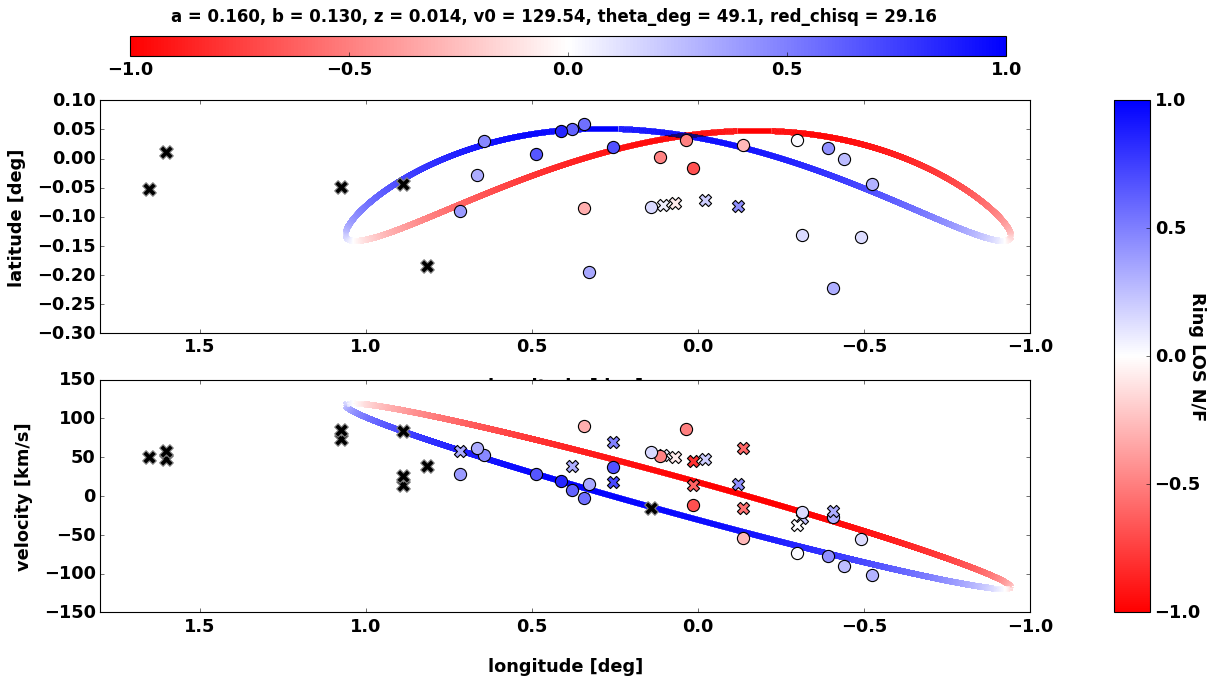

235 235


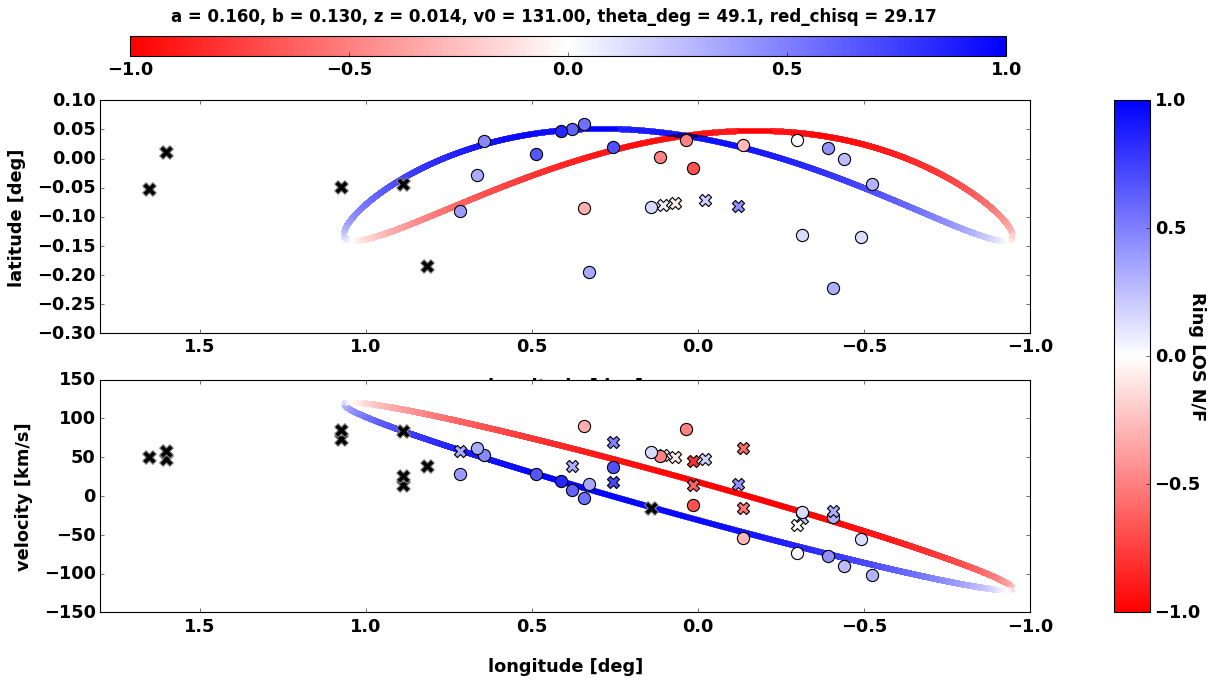

240 240


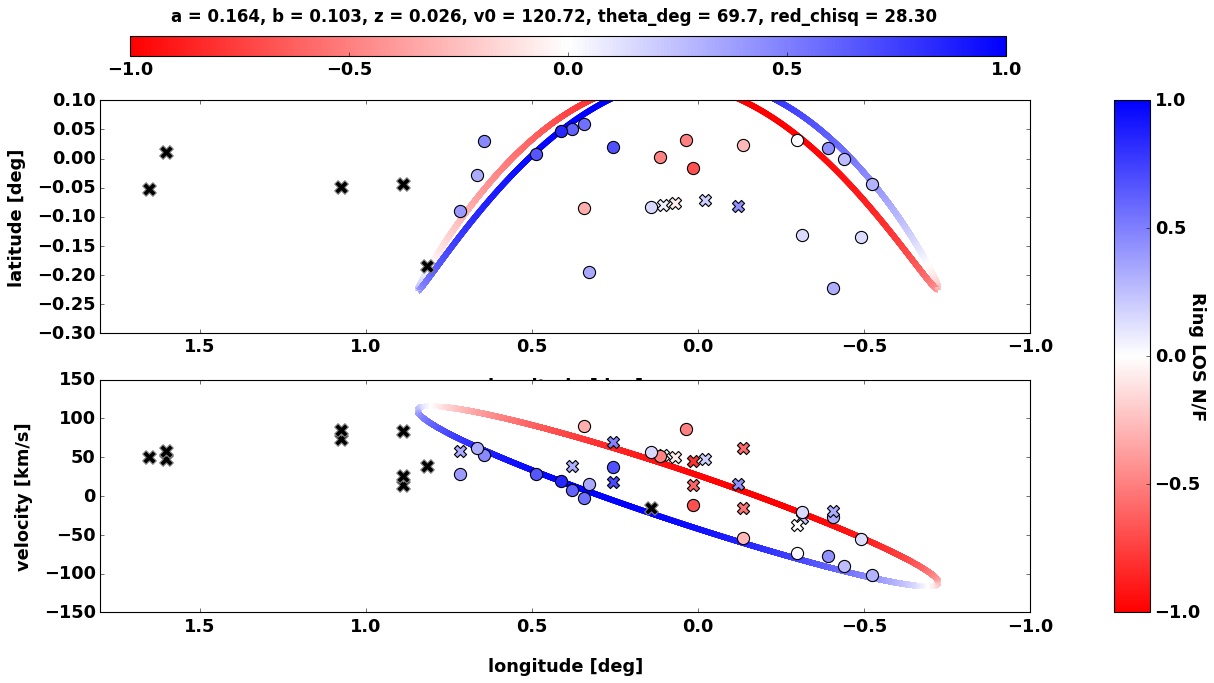

245 245


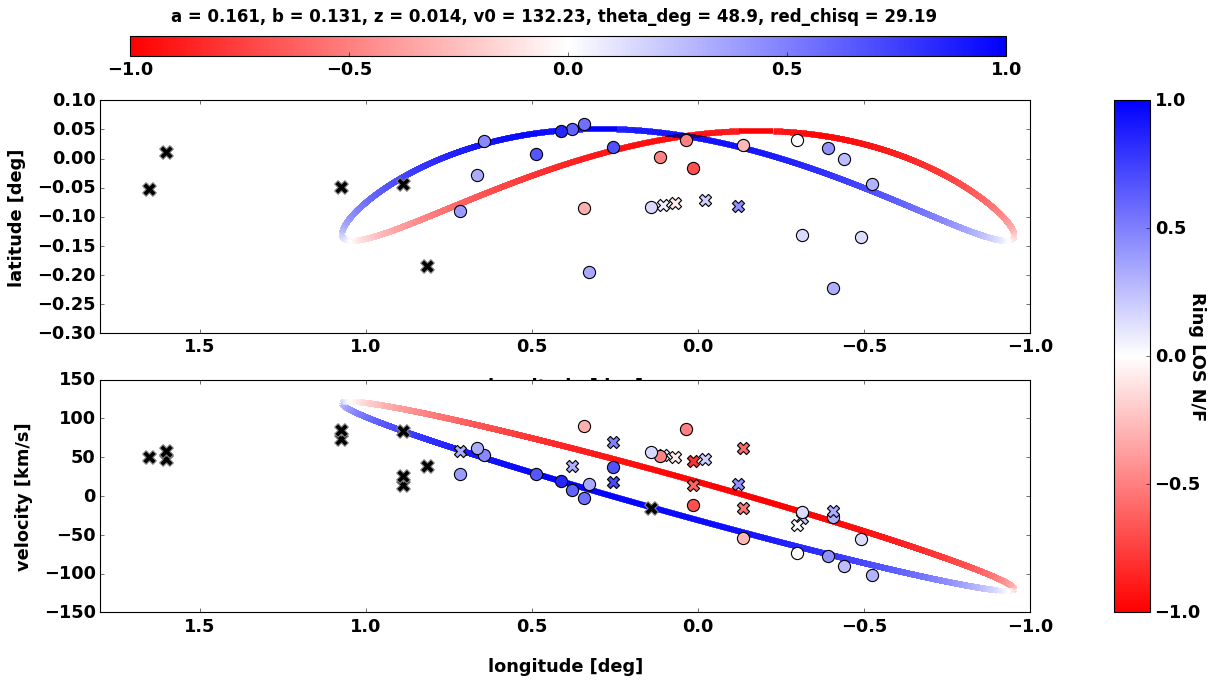

250 250


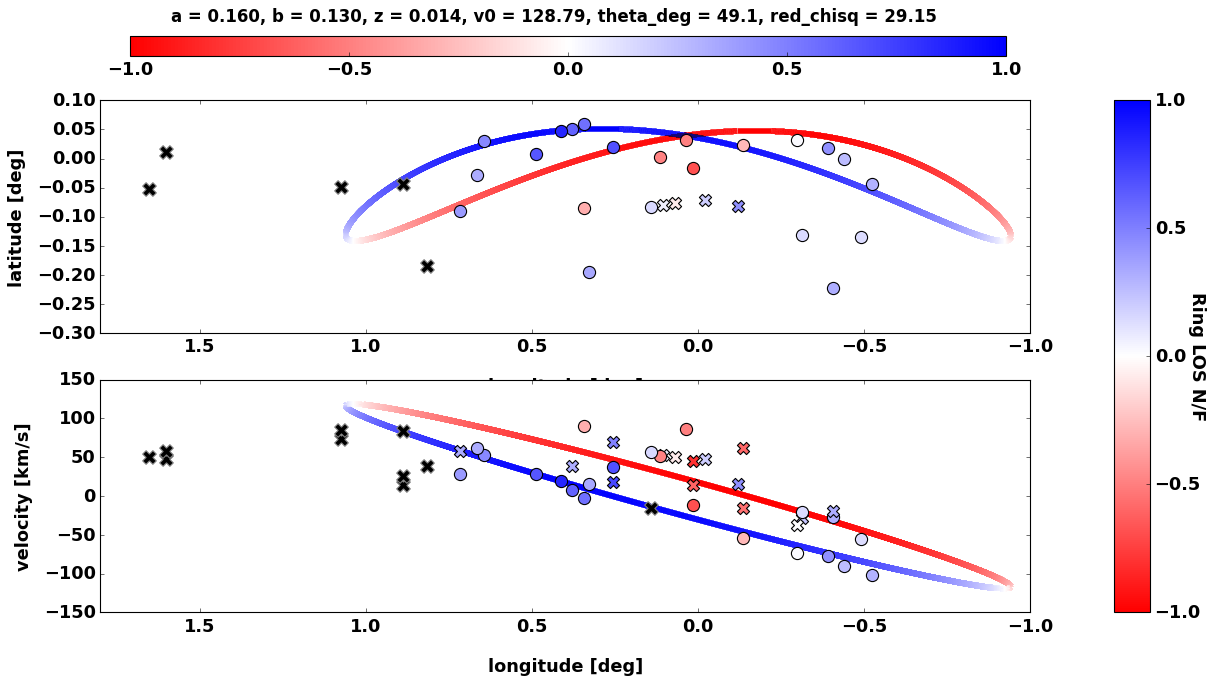

255 255


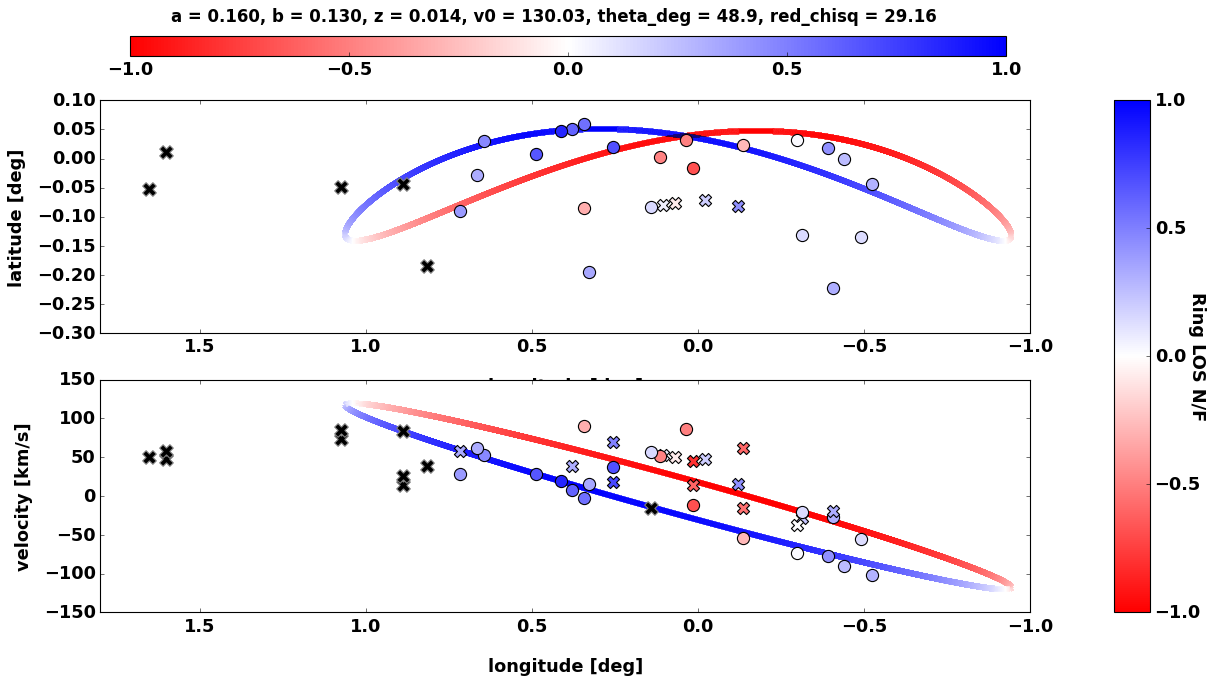

260 260


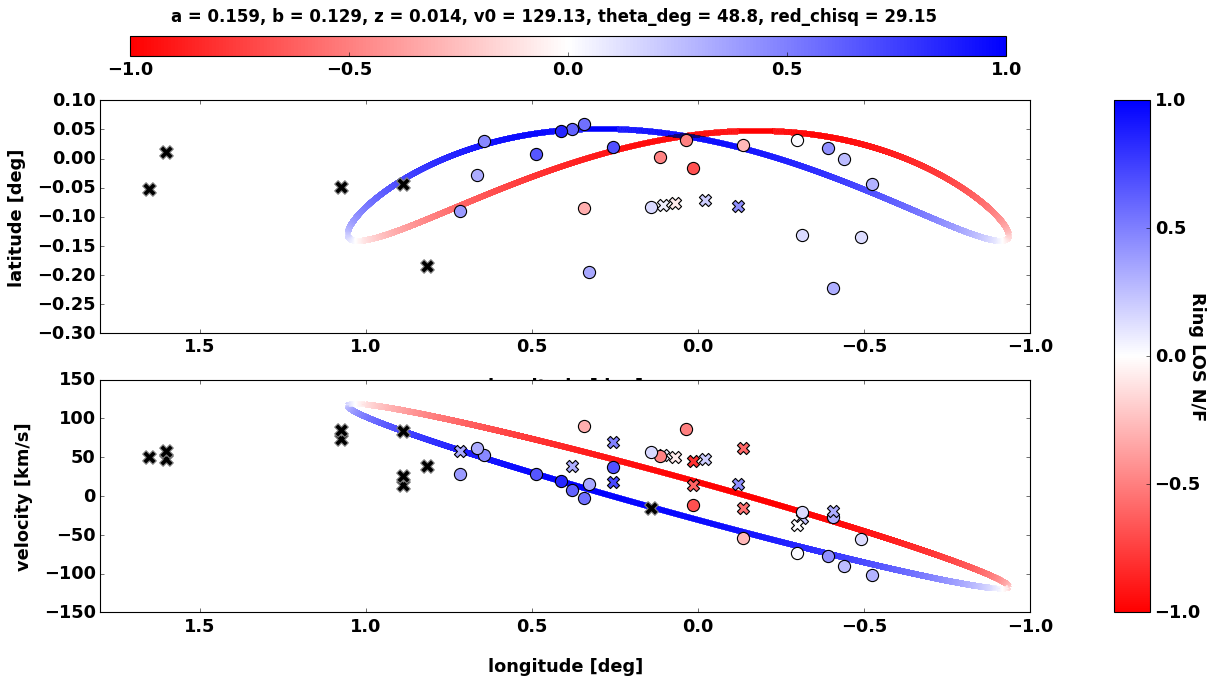

265 265


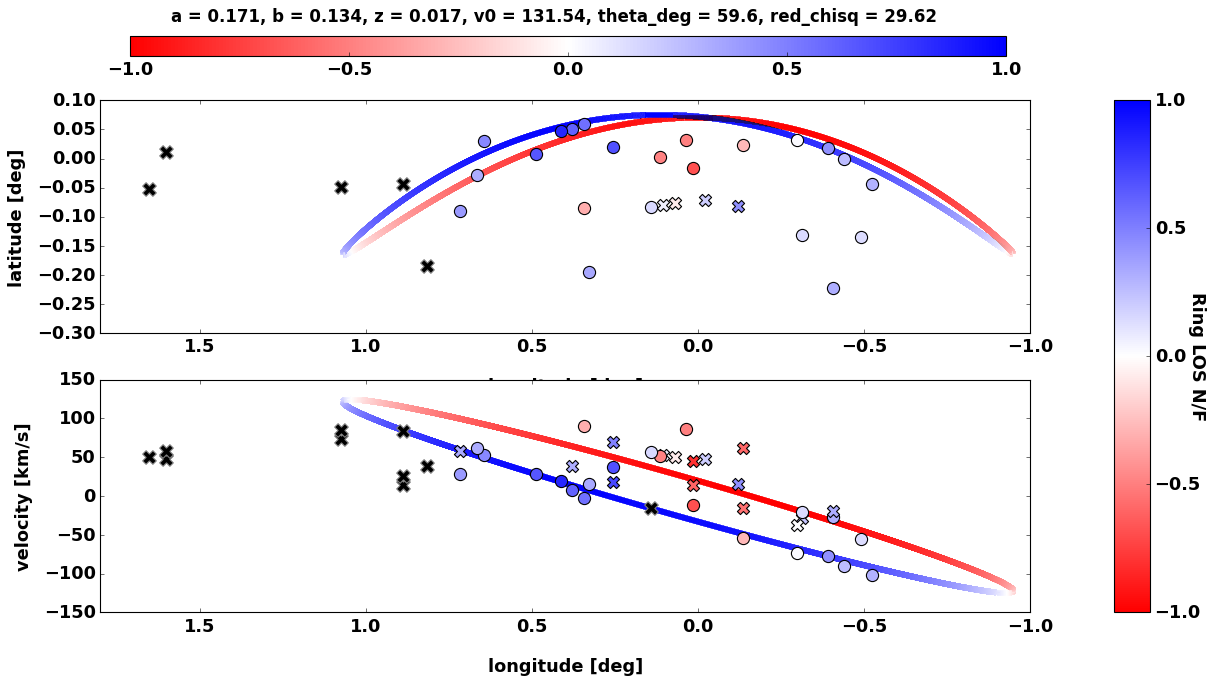

270 270


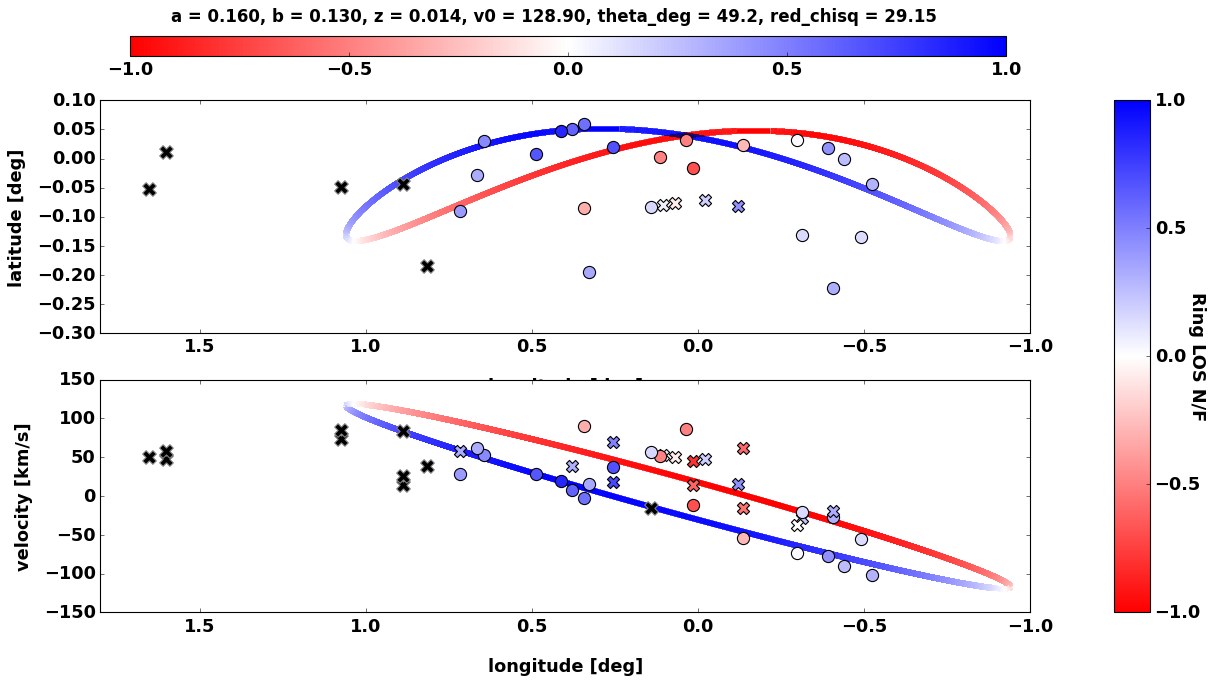

275 275


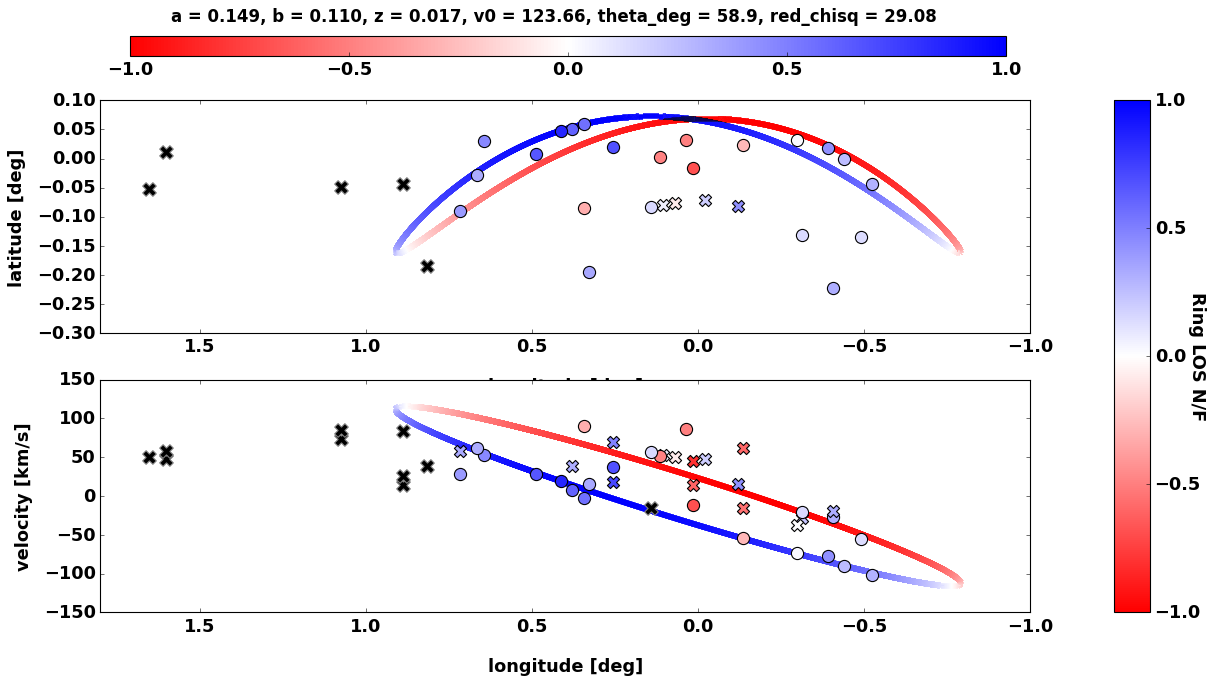

280 280


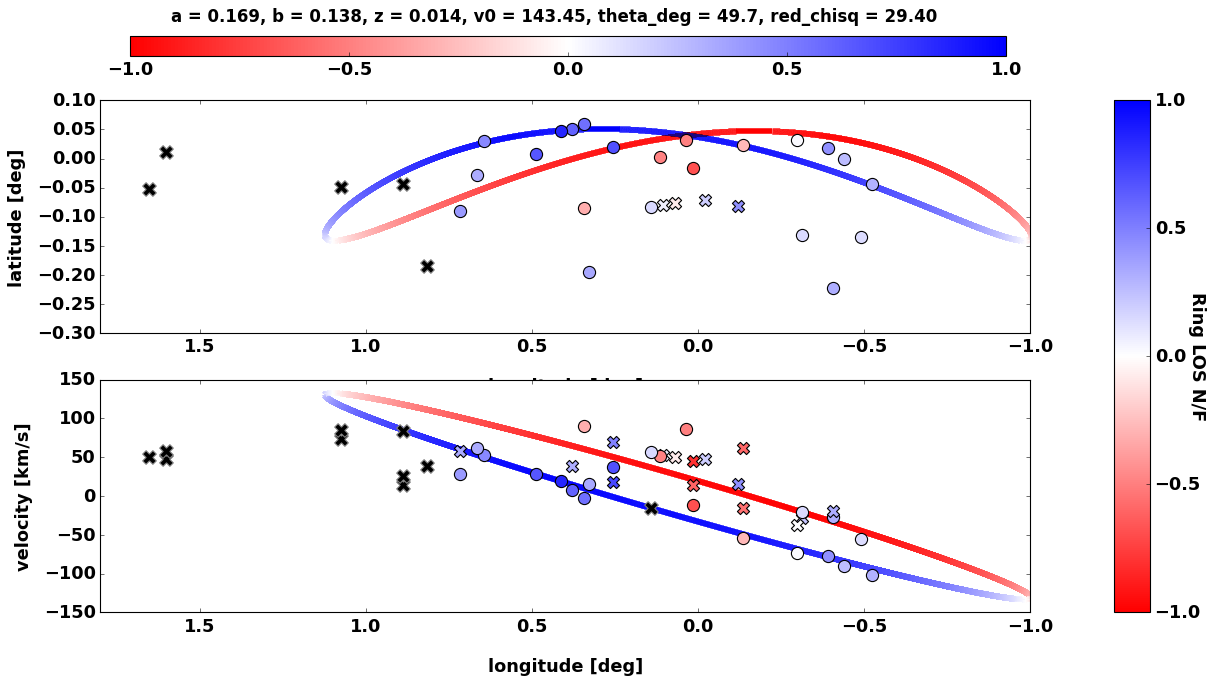

285 285


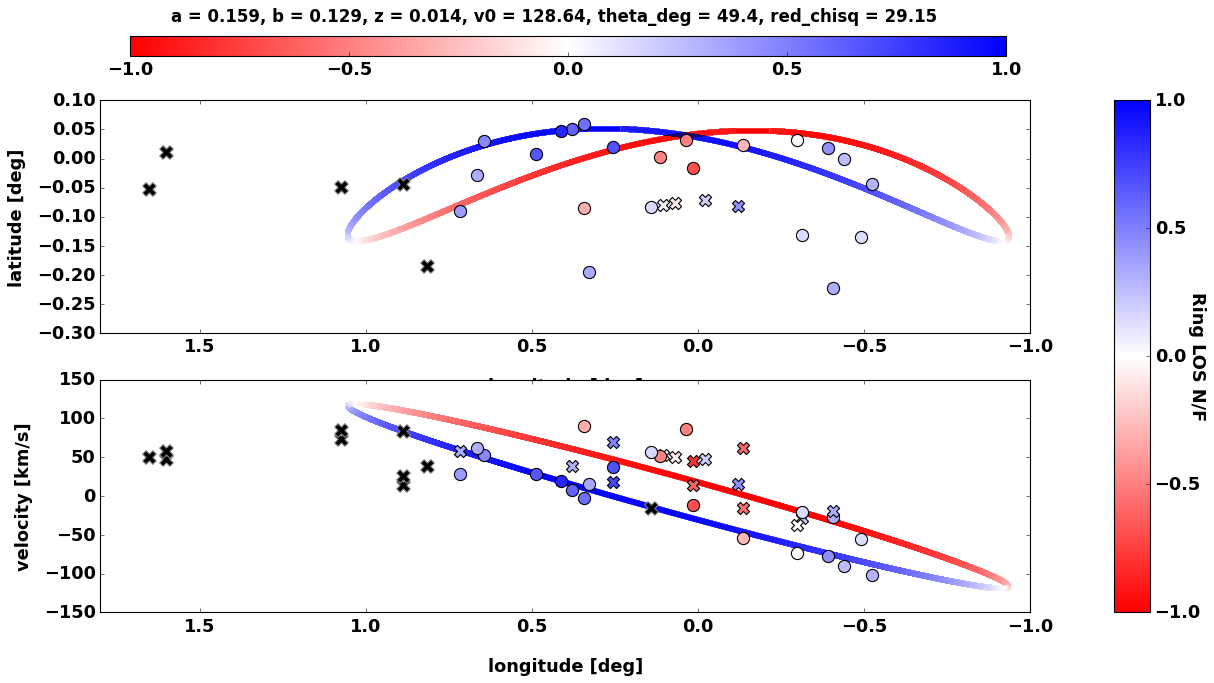

290 290


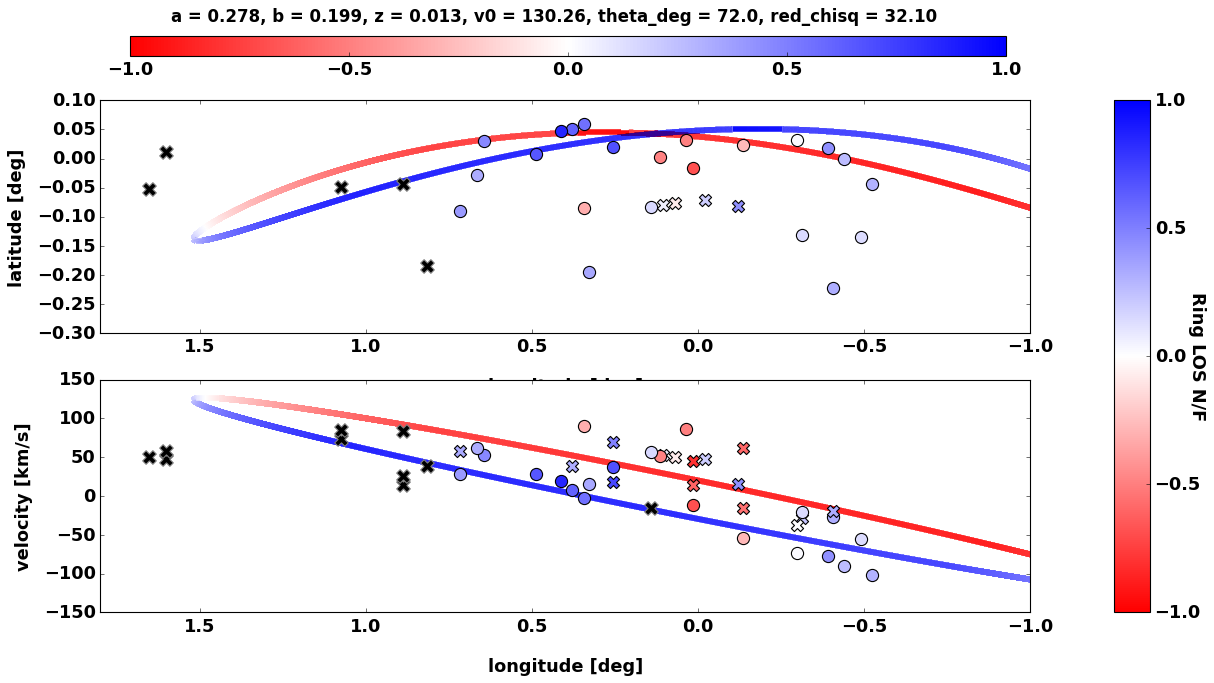

295 295


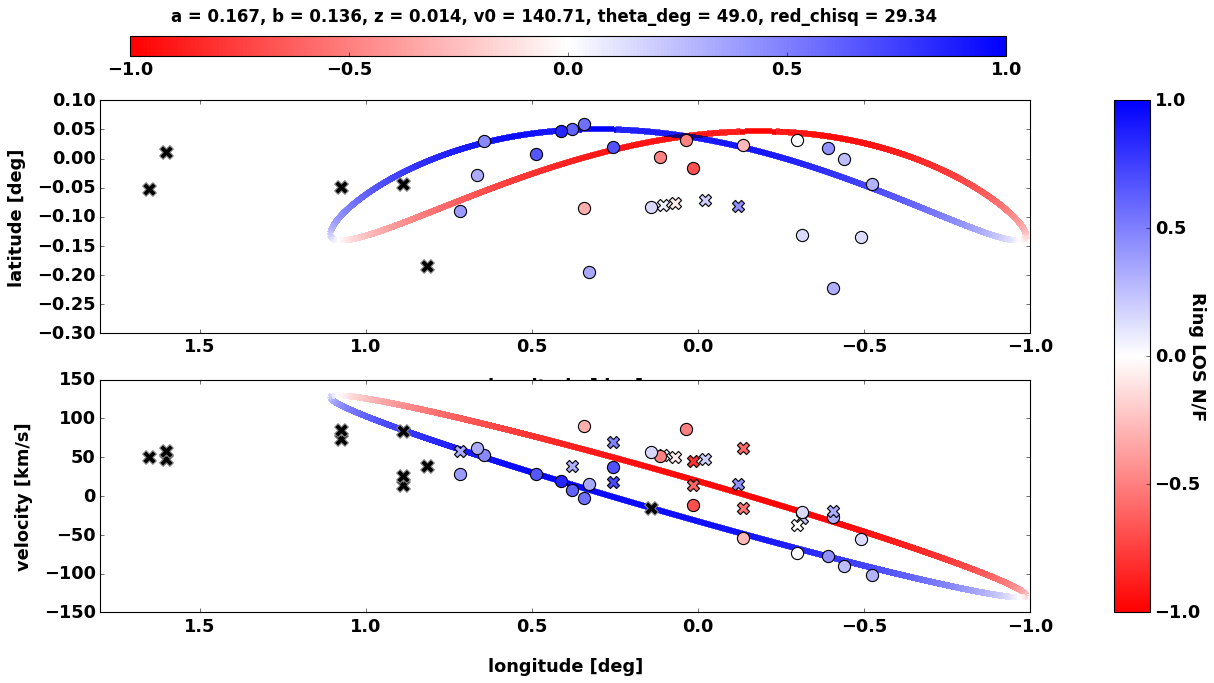

300 300


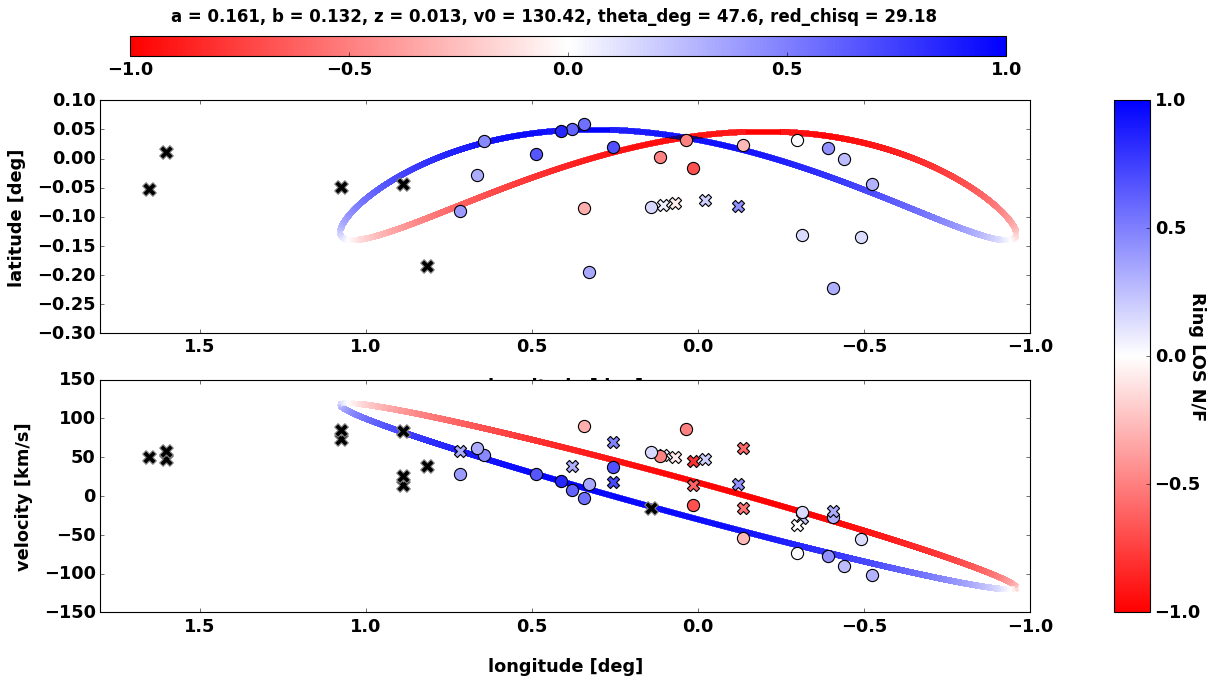

In [79]:
agrid = np.arange(10, 305, 5)
bgrid = np.arange(10, 305, 5)

grid_tab = Table()
r0, a_out, b_out, z_out, v_out, theta_out, redchisq = [], [], [], [], [], [],[]

for i in range(len(agrid)):
    print(agrid[i],bgrid[i])

    params_GRID = create_params(a_rings={'value': agrid[i]/1e3   , 'min': 0.01, 'max': 0.3, 'vary': True},
                               b_rings={'value': bgrid[i]/1e3  , 'min': 0.01, 'max': 0.2, 'vary': True},
                               z_rings={'value': 0.0125 , 'min': 0.00, 'max': 0.05, 'vary': True},
                               v_rings={'value': 130.0  , 'min': 100.0, 'max': 150.0, 'vary': True},
                               theta_rings={'value': 25  , 'min': 15, 'max': 360, 'vary': True},
                               ddphi={'value': 0.001  , 'min': 0.00005, 'max': 0.01, 'vary': False}
                                  )
    
    out = minimize(ring_resid, params_GRID, method='nelder', args=(Ndata.l0,Ndata.b0,Ndata.v0))
    
        
    #if (np.mean(Rings_out.vr[ring_NF_dist(Rings_out)[1]])<np.mean(Rings_out.vr[ring_NF_dist(Rings_out)[0]])):
    
    dphi = np.radians(0.001)
    phi  = arange(phisun+dphi/2,phisun+2*pi,dphi)

    Rings_out = Ring(phi,
                      out.params['a_rings'].value,
                      out.params['b_rings'].value,
                      out.params['z_rings'].value,
                      out.params['v_rings'].value, 
                      np.radians(out.params['theta_rings'].value),
                      xyzsun,vxyzsun)


    N_cent_vr = Rings_out.vr[np.argmin(abs(Rings_out.l[ring_NF_dist(Rings_out)[1][0]]))]
    F_cent_vr = Rings_out.vr[np.argmin(abs(Rings_out.l[ring_NF_dist(Rings_out)[0][0]]))]
    if (N_cent_vr<F_cent_vr):
        lb_lv_plots_postcolor_grad(Rings_out, out)
        
        r0.append(agrid[i])
        a_out.append(out.params['a_rings'].value)
        b_out.append(out.params['b_rings'].value)
        z_out.append(out.params['z_rings'].value)
        v_out.append(out.params['v_rings'].value)
        theta_out.append(out.params['theta_rings'].value)
        redchisq.append(out.redchi)

In [43]:
Rings_out.vr[np.argmin(abs(Rings_out.l[ring_NF_dist(Rings_out)[0][0]]))]

24.161119368730777

In [42]:
Rings_out.vr[np.argmin(abs(Rings_out.l[ring_NF_dist(Rings_out)[1][0]]))]

-36.405272185688645

Text(0.5, 0, 'redchisq')

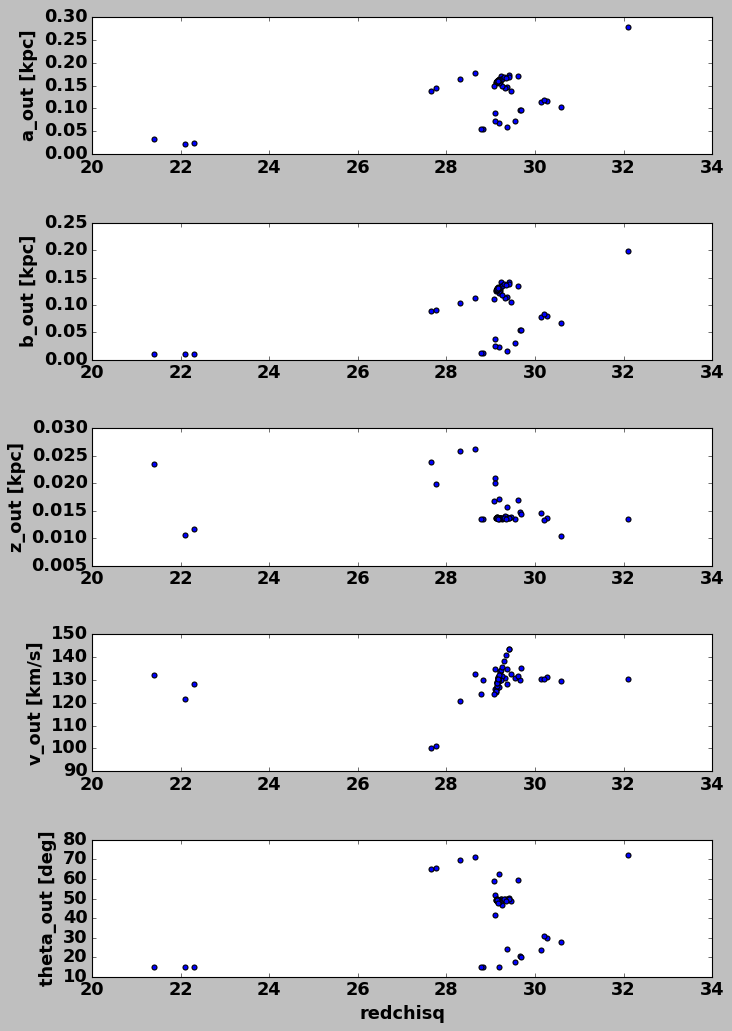

In [96]:
fig, ax = plt.subplots(5, 1,  figsize=(10, 15))
plt.subplots_adjust(hspace=0.5)
ax[0].scatter(redchisq, a_out)
ax[1].scatter(redchisq, b_out)
ax[2].scatter(redchisq, z_out)
ax[3].scatter(redchisq, v_out)
ax[4].scatter(redchisq, theta_out)




ax[0].set_ylabel('a_out [kpc]')
ax[1].set_ylabel('b_out [kpc]')
ax[2].set_ylabel('z_out [kpc]')
ax[3].set_ylabel('v_out [km/s]')
ax[4].set_ylabel('theta_out [deg]')
ax[4].set_xlabel('redchisq')

In [78]:
a_out

[0.02449562880892635,
 0.03275183827432386,
 0.055562652719167445,
 0.022958623391033915,
 0.0672043909653395,
 0.05391209894321358,
 0.07337287821865052,
 0.13793958678219806,
 0.09015759161543607,
 0.05919851161580798,
 0.09674715295194161,
 0.0728210719222002,
 0.0956475489129554,
 0.10221541040017786,
 0.11560633875736685,
 0.11449348466346115,
 0.11828982197384551,
 0.1583439899103055,
 0.1593909755090548,
 0.13915951143866698,
 0.1783654044721253,
 0.1603220622266842,
 0.15682717836168716,
 0.15711416650911583,
 0.1474194801281895,
 0.16415260336176388,
 0.16042204826890033,
 0.14514940955120068,
 0.14924803163510908,
 0.15531669321446476,
 0.16178839737171696,
 0.17031631167812208,
 0.14532698825972876,
 0.16495430798538144,
 0.16541333332503375,
 0.16818944242339823,
 0.15535202847238824,
 0.17279455098475416,
 0.16076057678735917,
 0.15693281397767256,
 0.15881064151687116,
 0.16059871620256747,
 0.15997562135206597,
 0.15801828709916588,
 0.15967706807808005,
 0.1604238609830

In [64]:
len(np.arange(5, 305, 5))

60